## 0. Data Import

In [1]:
#uncomment to download required packages
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import scipy.stats as stats
from arch import arch_model
%config InlineBackend.figure_format = 'retina'

In [3]:
tesla_df = pd.read_csv('QRM-2025-cw2-data.csv')
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
#compute the log returns in %
tesla_df['log_returns'] = 100*(np.log(tesla_df.TSLA) - np.log(tesla_df.TSLA.shift(1)))
tesla_df['loss'] = -tesla_df.log_returns
tesla_df['loss'].count()

np.int64(2518)

In [4]:
tesla_df.head()

,Date,TSLA,log_returns,loss
0,2012-11-26,2.151333,NaN,NaN
1,2012-11-27,2.143333,-0.372556,0.372556
2,2012-11-28,2.215333,3.304064,-3.304064
3,2012-11-29,2.246000,1.374813,-1.374813
4,2012-11-30,2.254667,0.385143,-0.385143


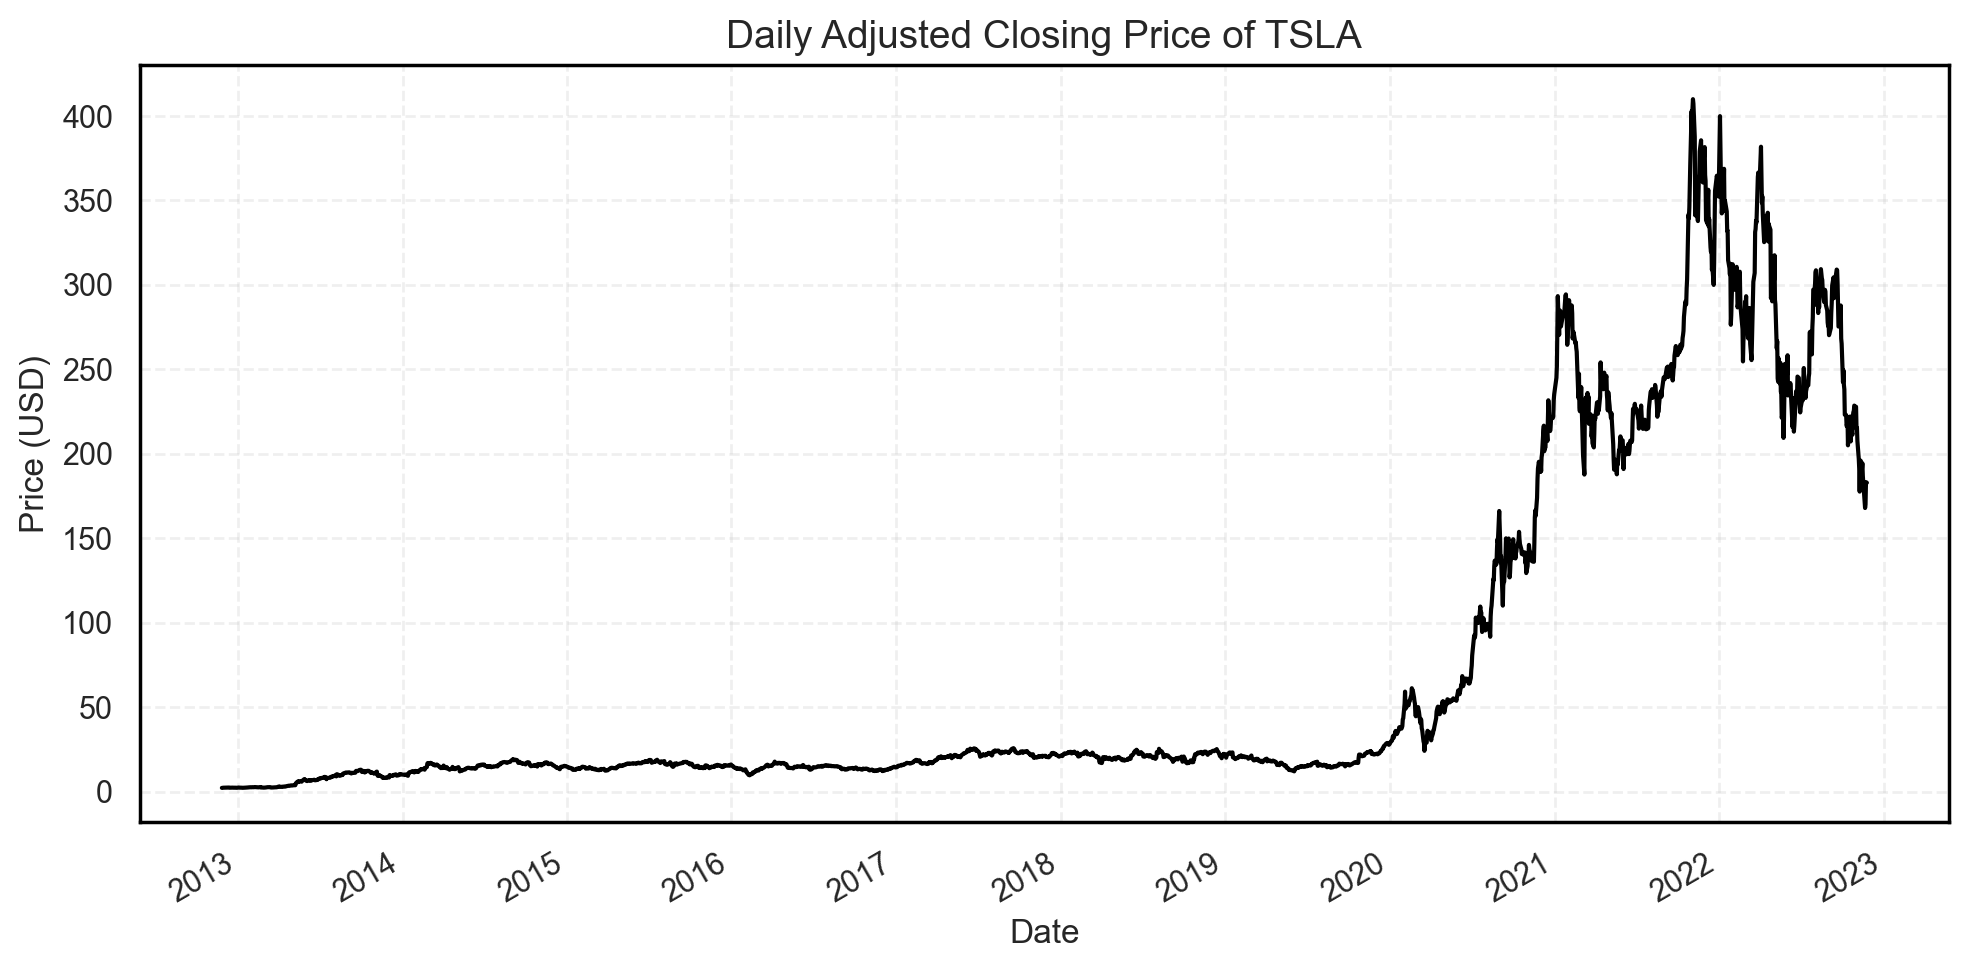

In [198]:
from datetime import datetime
sns.set_theme(style="white", rc={"axes.edgecolor":"black"})
plt.figure(figsize=(10, 5))  # good ratio for LaTeX reports
plt.plot(tesla_df['Date'], tesla_df['TSLA'], linewidth=1.5, color='black')


# Title and labels
plt.title("Daily Adjusted Closing Price of TSLA", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)

# Improve date formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())      # one tick per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # rotate dates for readability
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# Export to PDF
plt.savefig("TSLA_price.pdf", format="pdf", dpi=300)

# Show the figure (optional)
plt.show()

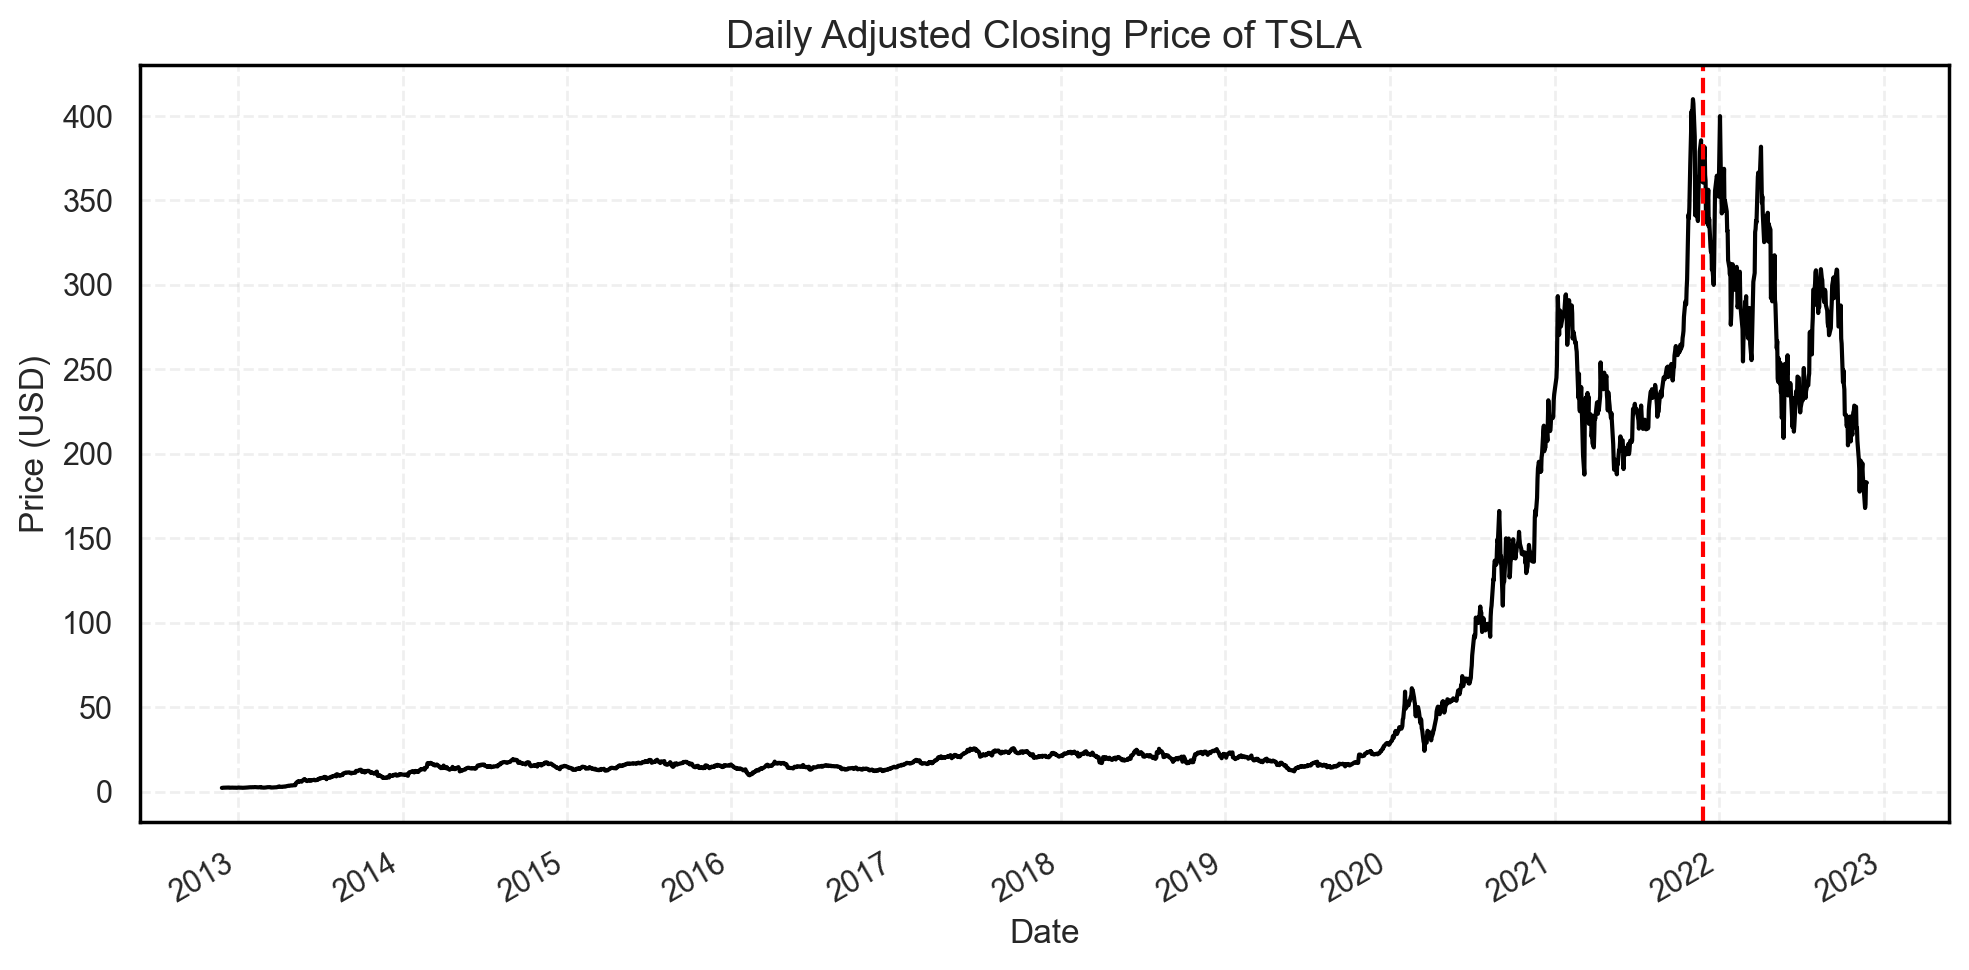

In [199]:
from datetime import datetime
sns.set_theme(style="white", rc={"axes.edgecolor":"black"})
plt.figure(figsize=(10, 5))  # good ratio for LaTeX reports
plt.plot(tesla_df['Date'], tesla_df['TSLA'], linewidth=1.5, color='black')

split_date = datetime(2021, 11, 26)
plt.axvline(x=split_date, color='red', linestyle='--')

# Title and labels
plt.title("Daily Adjusted Closing Price of TSLA", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)

# Improve date formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())      # one tick per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # rotate dates for readability
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# Export to PDF
plt.savefig("TSLA_price_split.pdf", format="pdf", dpi=300)

# Show the figure (optional)
plt.show()

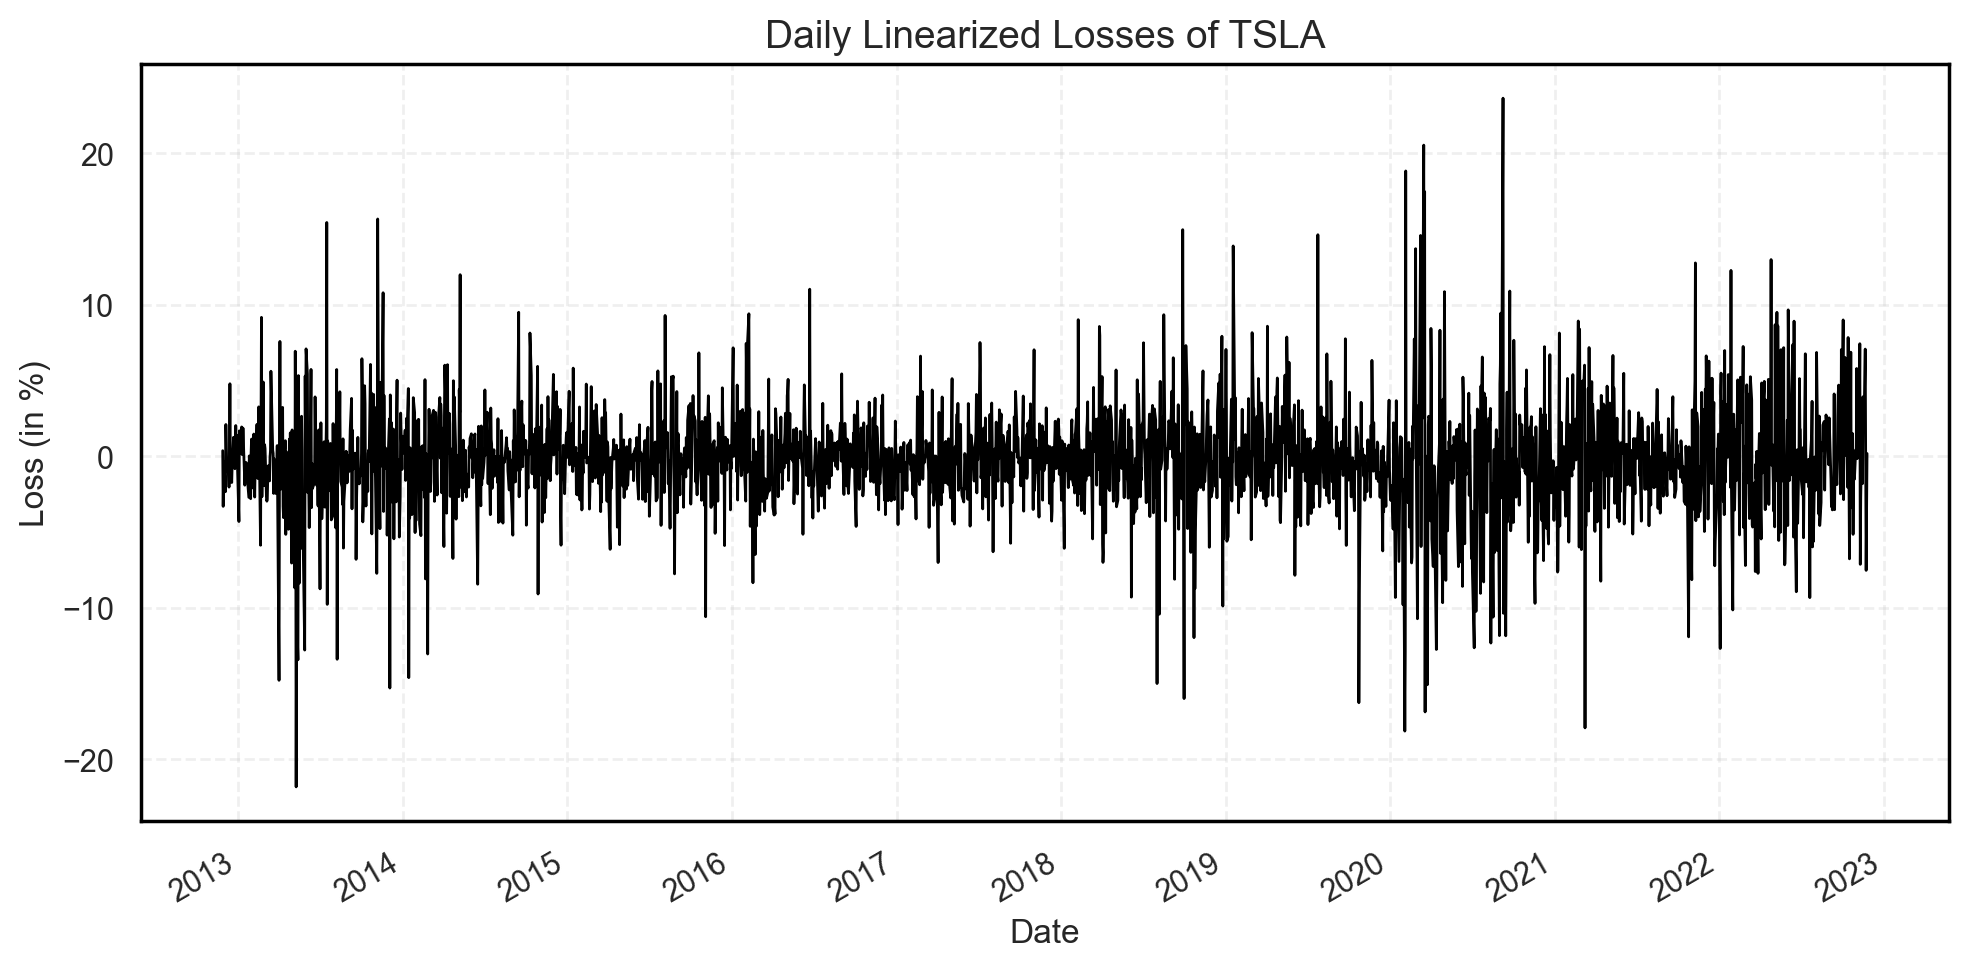

In [6]:
sns.set_theme(style="white", rc={"axes.edgecolor":"black"})

plt.figure(figsize=(10, 5))

# Plot losses
plt.plot(tesla_df['Date'], tesla_df['loss'], color='black', linewidth=1)

# Labels and title
plt.title("Daily Linearized Losses of TSLA", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Loss (in %)", fontsize=12)

# Date formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Grid
plt.grid(alpha=0.3, linestyle='--')

# Tight layout
plt.tight_layout()

# Export high-quality PDF
plt.savefig("TSLA_losses.pdf", format="pdf", dpi=300)

plt.show()

--- 
## 1. Modeling on Training Data only 

In [7]:
train_df = tesla_df.loc[tesla_df.Date<'2021-11-26',:].dropna()
test_df = tesla_df.loc[tesla_df.Date>'2021-11-26',:].dropna()

In [215]:
train_df.loss.mean()

np.float64(-0.22739656682498535)

In [216]:
test_df.loss.mean()

np.float64(0.27058144790405964)

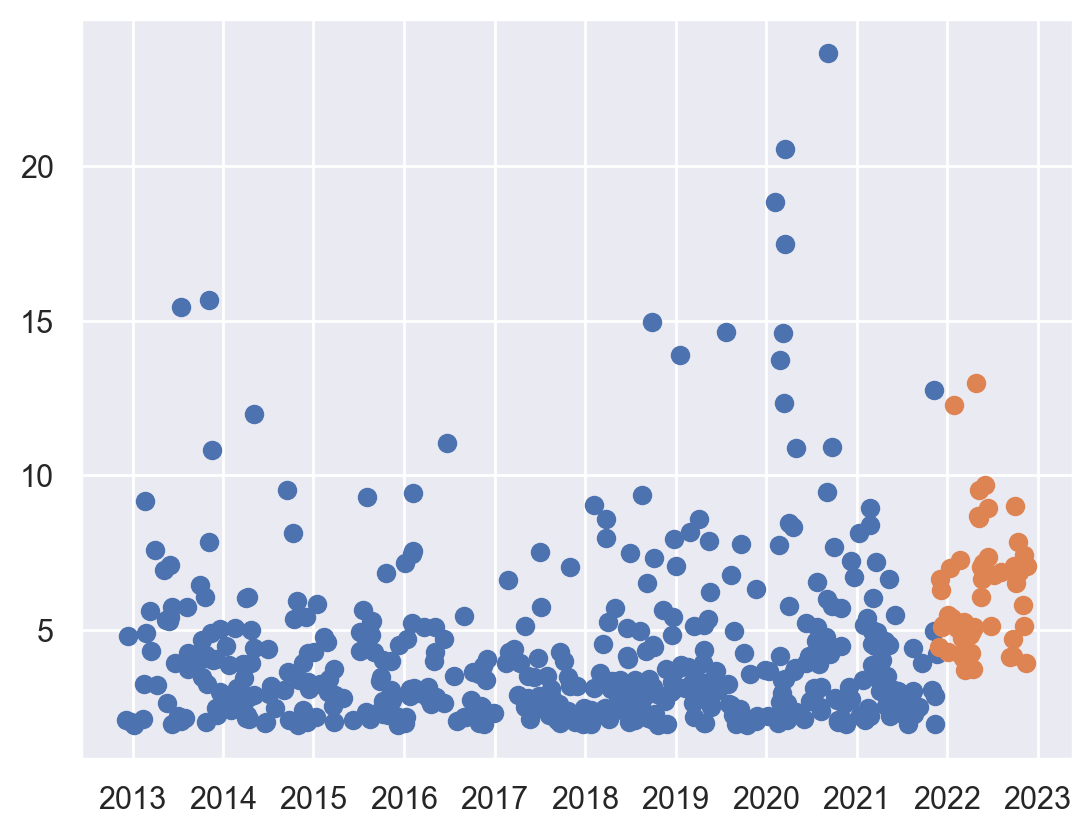

In [218]:
plt.scatter(train_df.loc[train_df.loss>np.quantile(train_df.loss, 0.8),'Date'], train_df.loc[train_df.loss>np.quantile(train_df.loss, 0.8)]['loss'])
plt.scatter(test_df.loc[test_df.loss>np.quantile(test_df.loss, 0.8),'Date'], test_df.loc[test_df.loss>np.quantile(test_df.loss, 0.8)]['loss'])
plt.savefig('q80losses.pdf')
plt.show()

In [8]:
train_df['log_returns'].count(), test_df['log_returns'].count()

(np.int64(2266), np.int64(251))

### Fit a GARCH(1,1) model to the loss

In [9]:
GARCH = arch_model(train_df['loss'], mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
res = GARCH.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109978.16287170455
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948164452209
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970838471652
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.871427110367
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501807425867
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.2480692428735
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7989571706585
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.349726412105
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254455983
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119614499
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900477
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900477
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations:

In [10]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Thu, Dec 04 2025   Df Residuals:                     2265
Time:                        10:37:26   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1506  6.417e-02     -2.347  1.892e-02 [ -0.2

In [11]:
res.std_resid

1       0.285321
2      -1.725954
3      -0.635443
4      -0.121605
5      -1.142008
          ...   
2262   -0.130877
2263   -0.891654
2264   -0.404564
2265    1.143070
2266   -0.123682
Name: std_resid, Length: 2266, dtype: float64

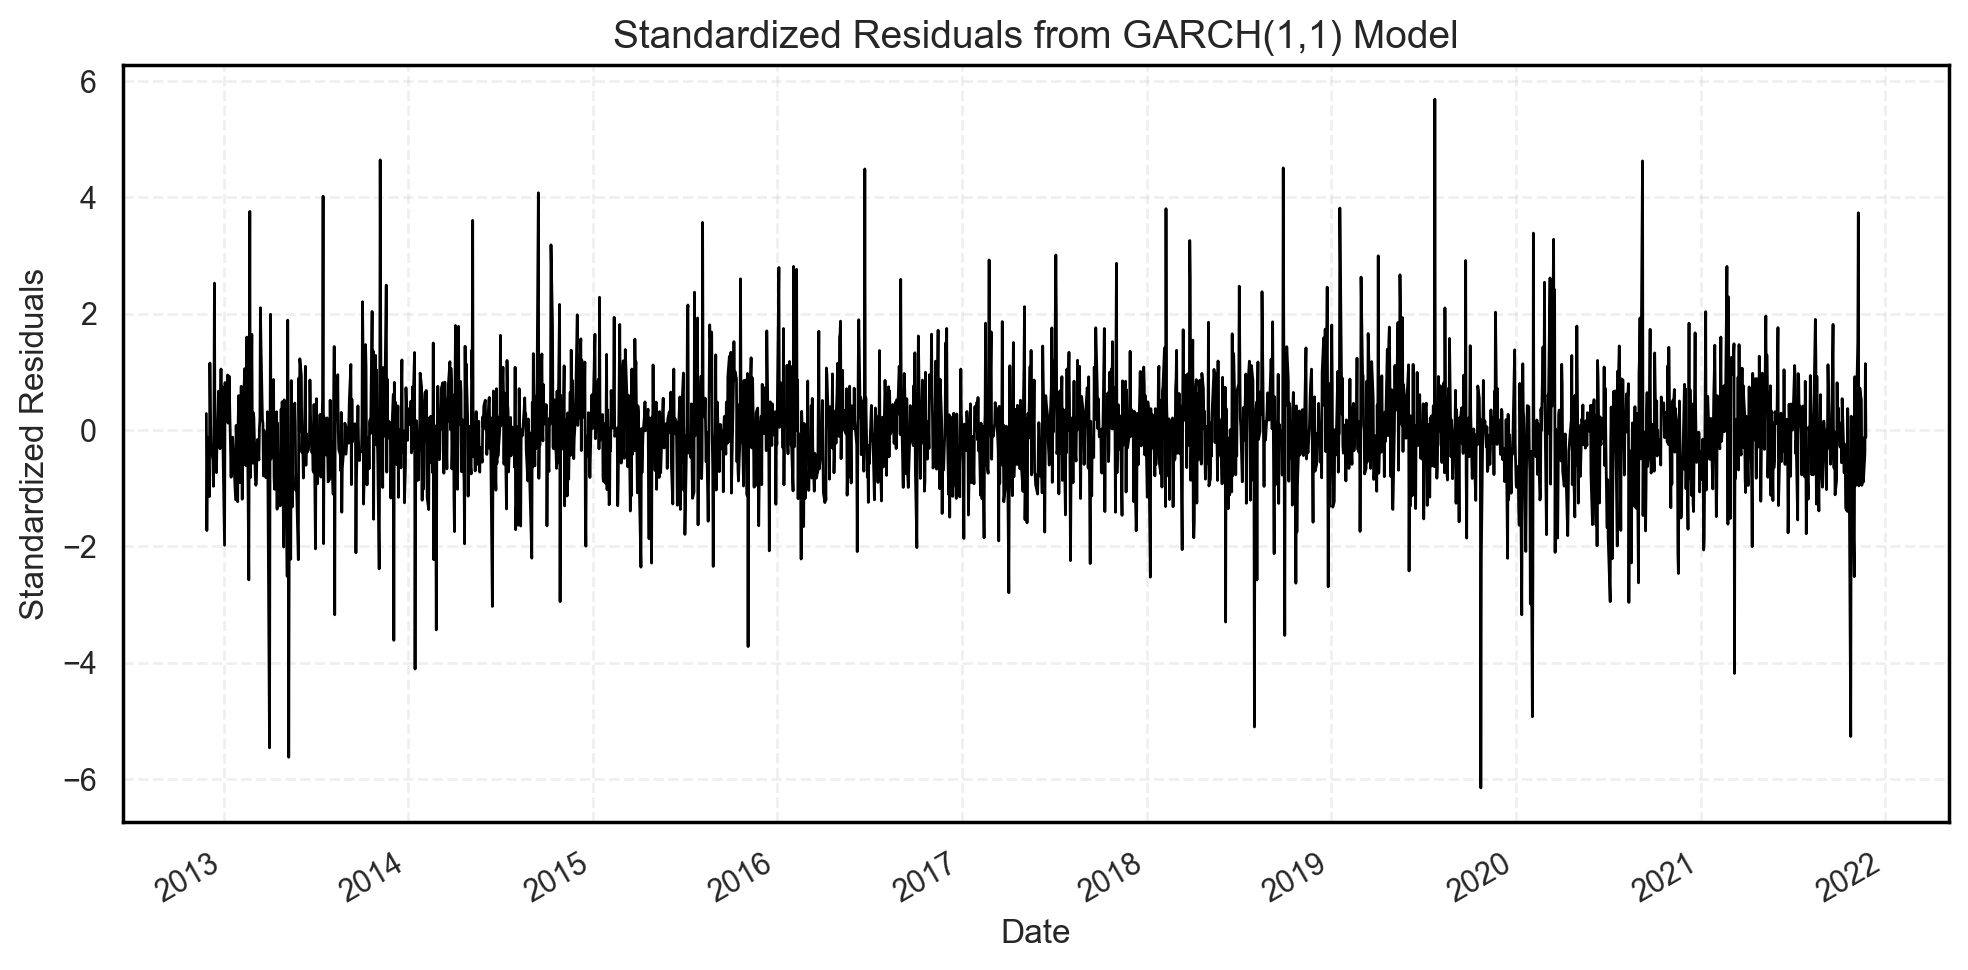

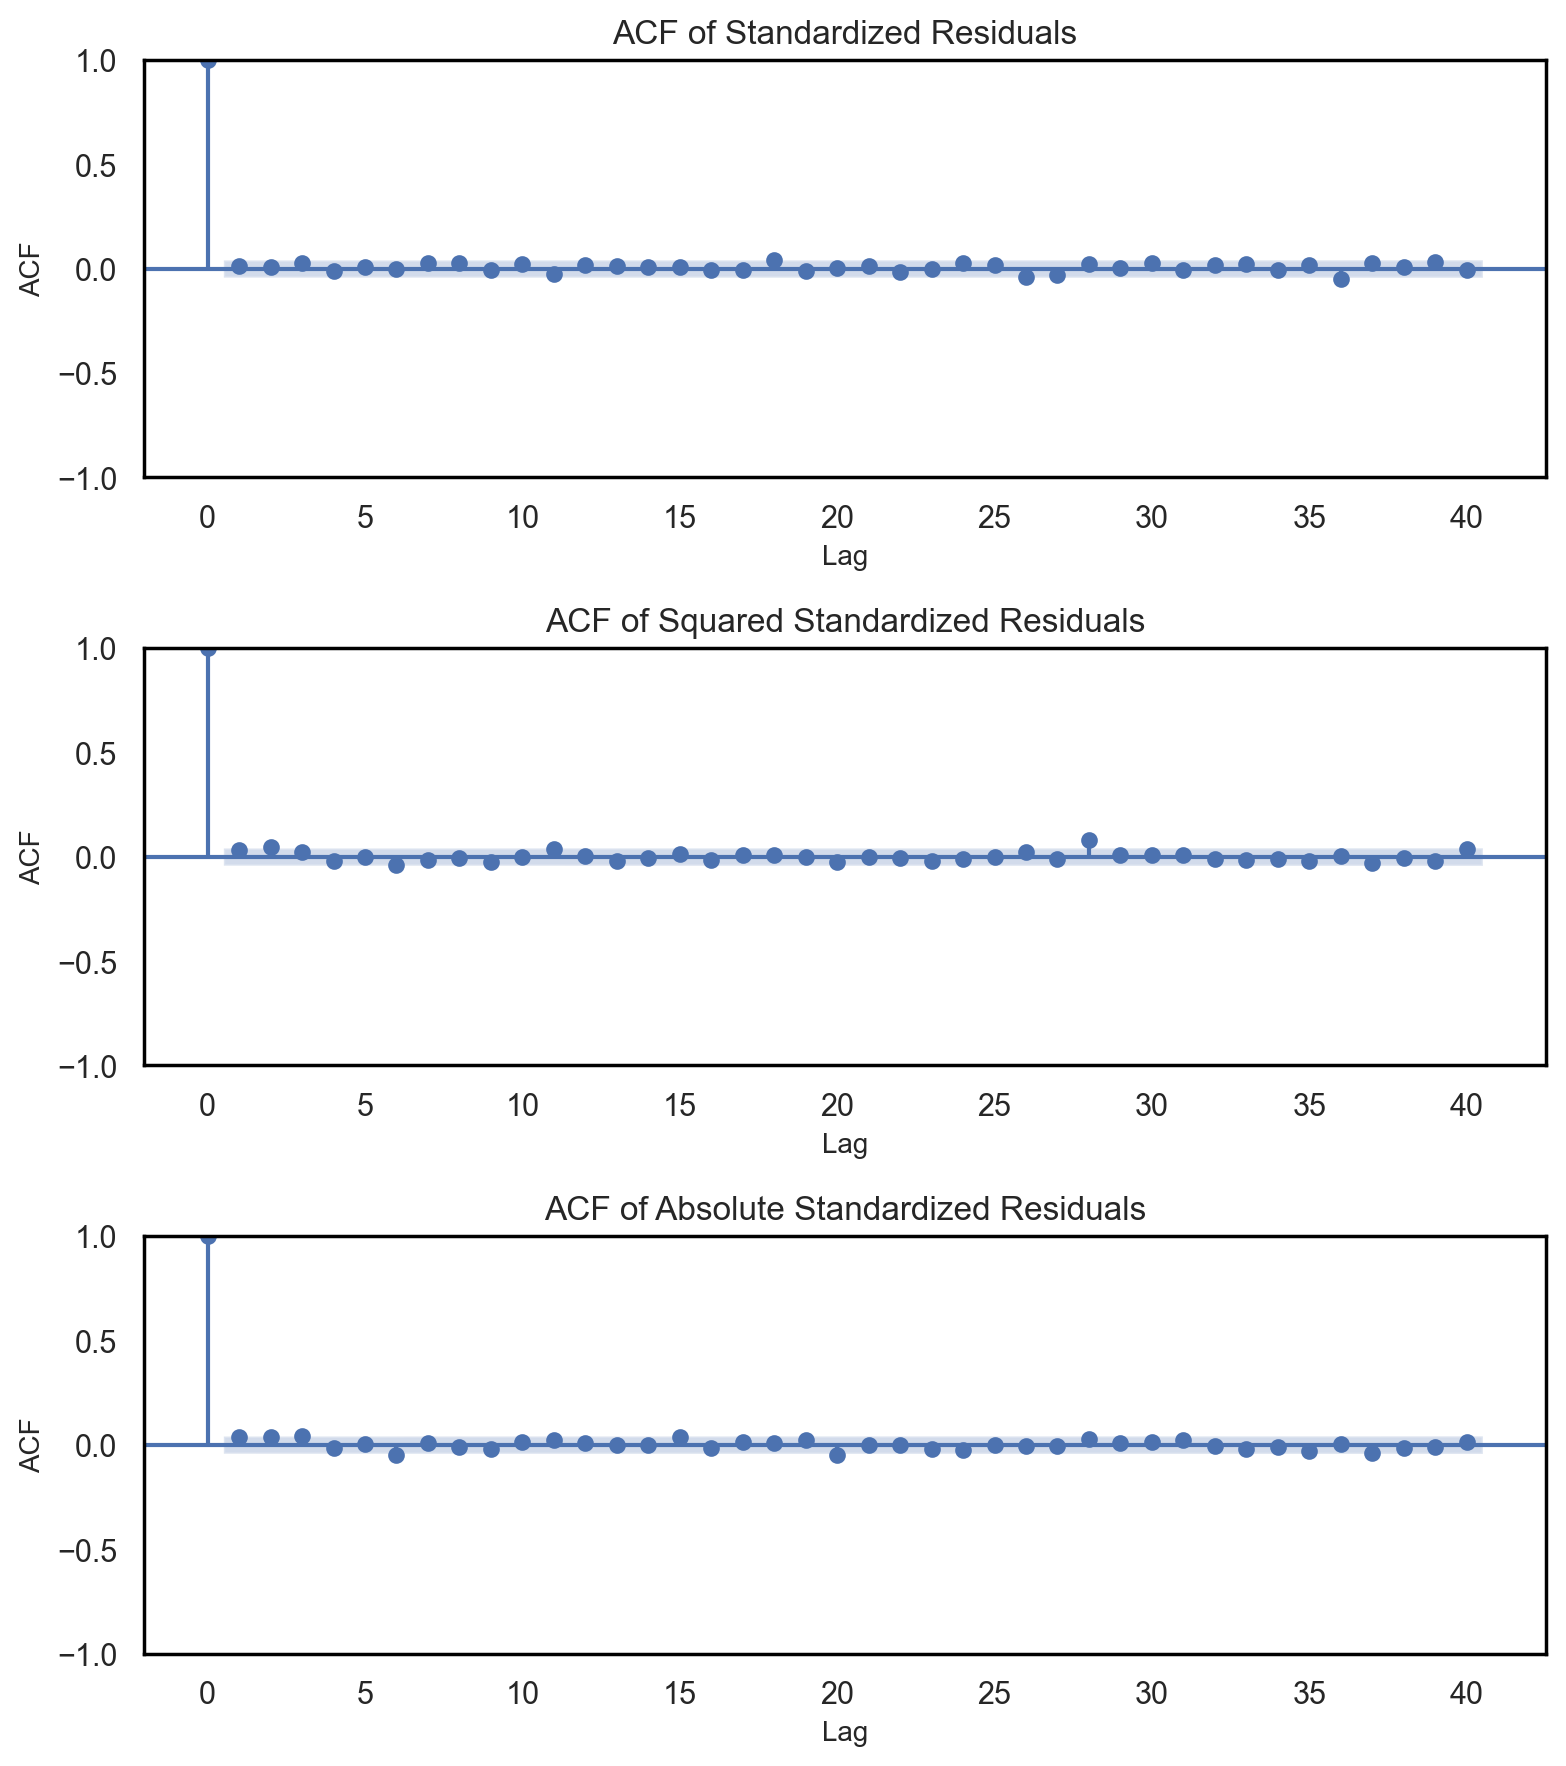

c:\Users\ilias\anaconda3\envs\qrm\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


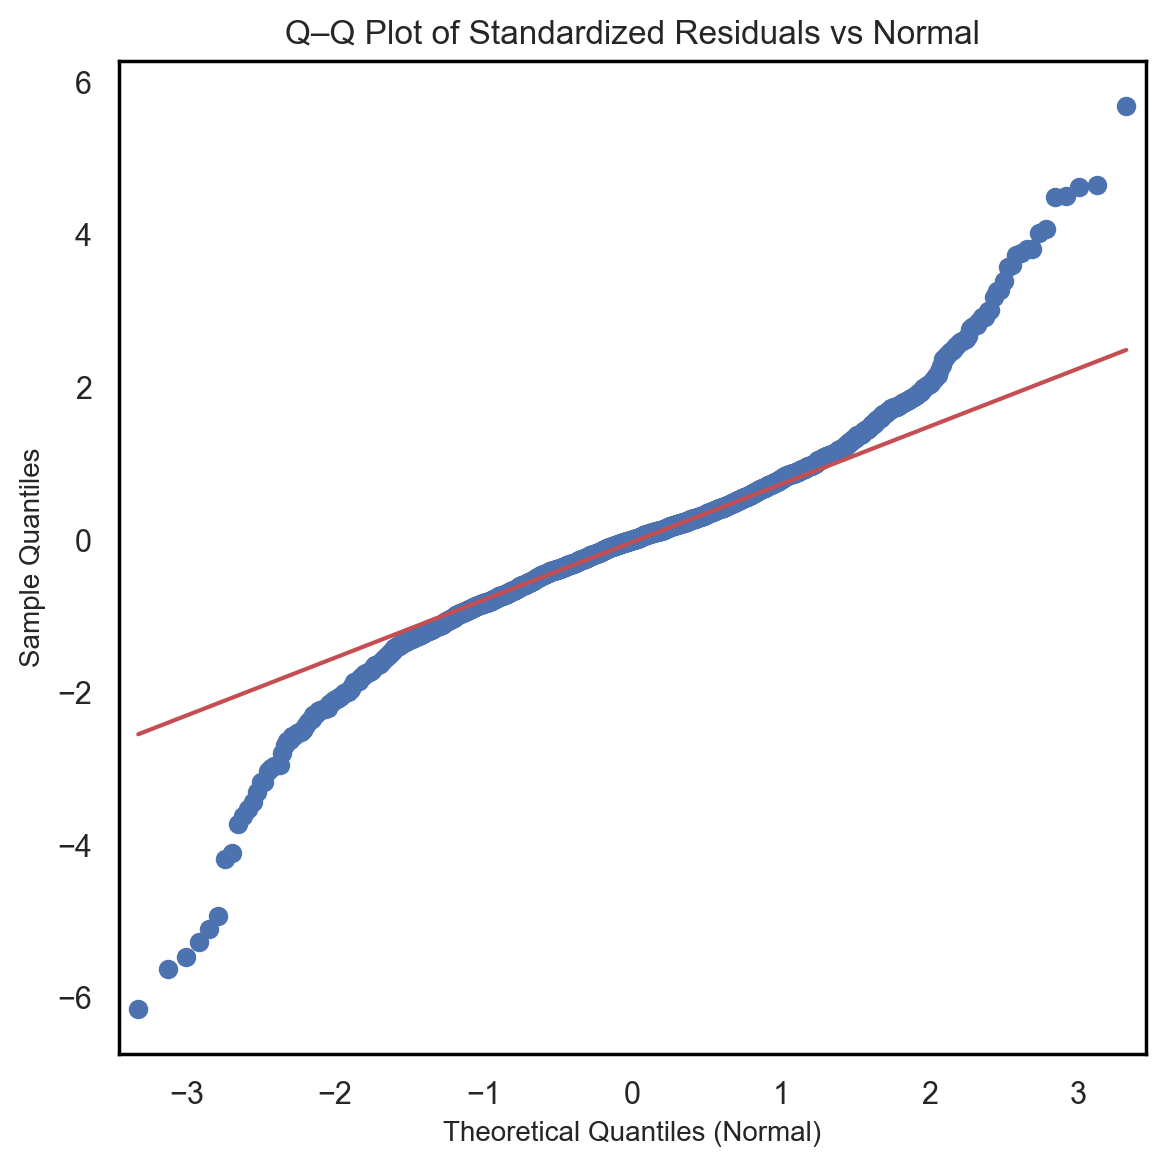

In [12]:
standardized_resid = res.std_resid

# === 1) Time series of standardized residuals ===
sns.set_theme(style="white", rc={"axes.edgecolor":"black"})
plt.figure(figsize=(10, 5))
plt.plot(train_df["Date"], standardized_resid, linewidth=1, color="black")

plt.title("Standardized Residuals from GARCH(1,1) Model", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Standardized Residuals", fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gcf().autofmt_xdate()

plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig("GARCH_standardized_residuals.pdf", format="pdf", dpi=300)
plt.show()


# === 2) ACF of residuals, squared residuals, and absolute residuals ===
fig, axes = plt.subplots(3, 1, figsize=(8, 9))

sm.graphics.tsa.plot_acf(standardized_resid, ax=axes[0], lags=40)
axes[0].set_title("ACF of Standardized Residuals", fontsize=12)
axes[0].set_xlabel("Lag", fontsize=10)
axes[0].set_ylabel("ACF", fontsize=10)

sm.graphics.tsa.plot_acf(standardized_resid**2, ax=axes[1], lags=40)
axes[1].set_title("ACF of Squared Standardized Residuals", fontsize=12)
axes[1].set_xlabel("Lag", fontsize=10)
axes[1].set_ylabel("ACF", fontsize=10)

sm.graphics.tsa.plot_acf(abs(standardized_resid), ax=axes[2], lags=40)
axes[2].set_title("ACF of Absolute Standardized Residuals", fontsize=12)
axes[2].set_xlabel("Lag", fontsize=10)
axes[2].set_ylabel("ACF", fontsize=10)

plt.tight_layout()
plt.savefig("GARCH_residuals_acf.pdf", format="pdf", dpi=300)
plt.show()


# === 3) Q-Q plot of standardized residuals vs Normal ===
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(standardized_resid, dist=stats.norm, ax=ax, line="q", color="black")

ax.set_title("Q–Q Plot of Standardized Residuals vs Normal", fontsize=12)
ax.set_xlabel("Theoretical Quantiles (Normal)", fontsize=10)
ax.set_ylabel("Sample Quantiles", fontsize=10)

plt.tight_layout()
plt.savefig("GARCH_residuals_qq.pdf", format="pdf", dpi=300)
plt.show()

residuals and squared residuals: non serially correlated -> consistent with independance assumption.

Tails seem heavier on the observed residuals distribution than on the theoretical normal distribution. 

In [13]:
from scipy.stats import norm, t

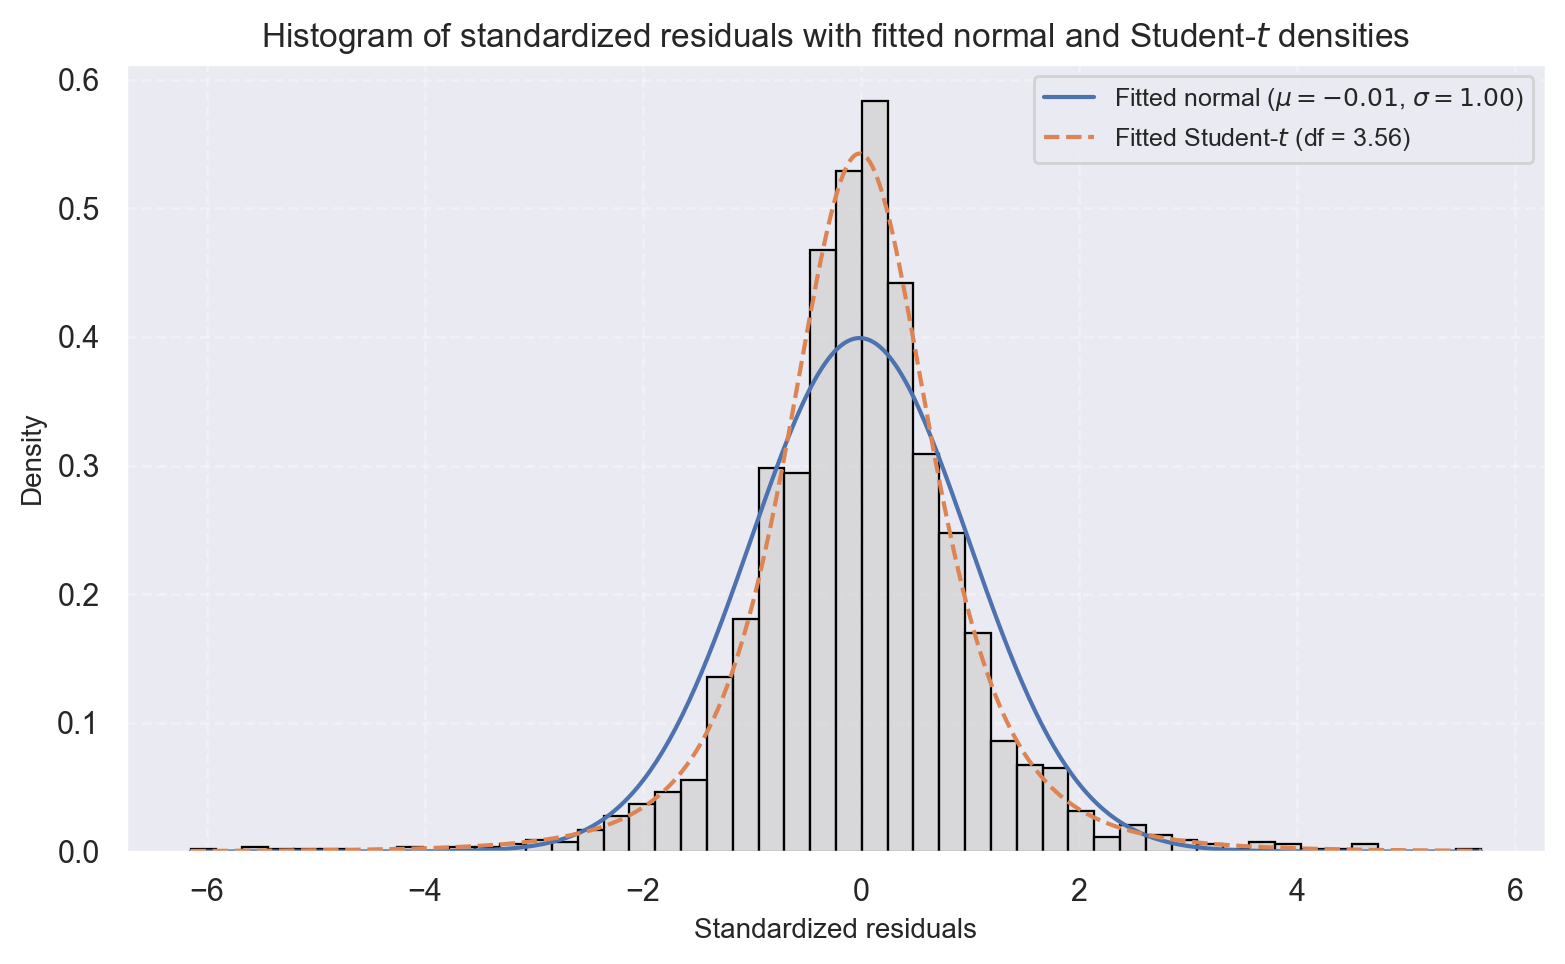

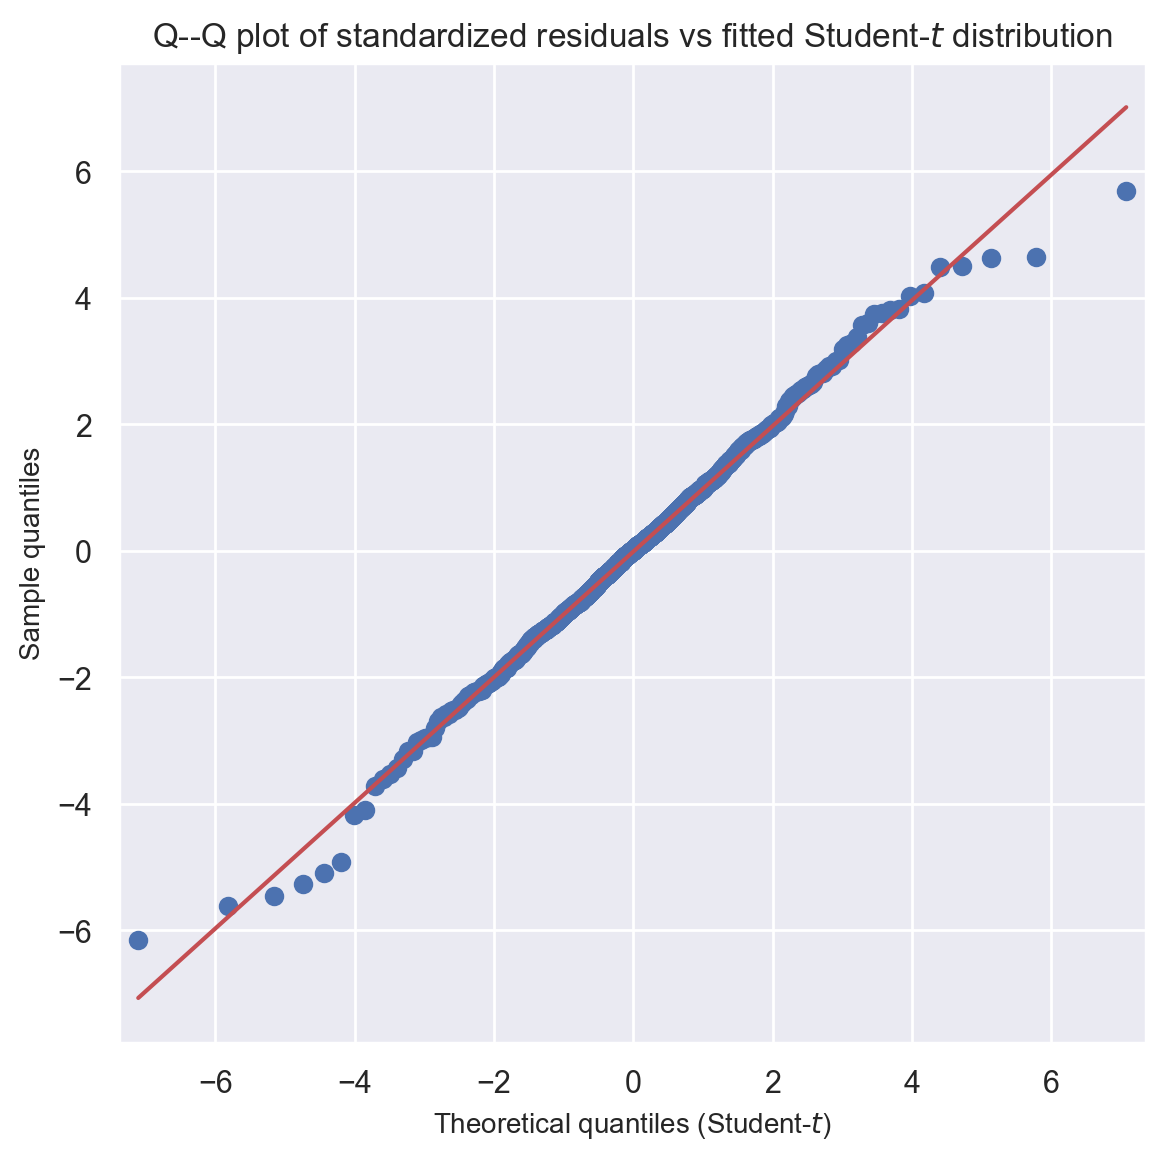

In [14]:
sns.set_theme()

# Fit Student-t distribution to standardized residuals
df_estimate, loc_estimate, scale_estimate = stats.t.fit(standardized_resid)

# === 1) Histogram + fitted Normal and Student-t densities ===
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram of standardized residuals (density)
sns.histplot(
    standardized_resid,
    bins=50,
    stat="density",
    color="lightgray",
    edgecolor="black",
    ax=ax,
)

# Grid of x values
xs = np.linspace(standardized_resid.min(), standardized_resid.max(), 400)

# Fitted Normal parameters
mean = np.mean(standardized_resid)
std = np.std(standardized_resid)

# Plot fitted Normal density
ax.plot(
    xs,
    stats.norm.pdf(xs, loc=mean, scale=std),
    linewidth=1.5,
    label=rf"Fitted normal ($\mu={mean:.2f}$, $\sigma={std:.2f}$)",
)

# Plot fitted Student-t density
ax.plot(
    xs,
    stats.t.pdf(xs, df_estimate, loc=loc_estimate, scale=scale_estimate),
    linewidth=1.5,
    linestyle="--",
    label=rf"Fitted Student-$t$ (df = {df_estimate:.2f})",
)

ax.set_title("Histogram of standardized residuals with fitted normal and Student-$t$ densities", fontsize=12)
ax.set_xlabel("Standardized residuals", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

ax.legend(fontsize=9)
ax.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.savefig("GARCH_resid_hist_fits.pdf", format="pdf", dpi=300)
plt.show()


# === 2) Q--Q plot vs fitted Student-t distribution ===

# Freeze the fitted Student-t distribution to avoid loc/scale conflicts
fitted_t = stats.t(df_estimate, loc=loc_estimate, scale=scale_estimate)

fig, ax = plt.subplots(figsize=(6, 6))

sm.qqplot(
    standardized_resid,
    dist=fitted_t,   # frozen distribution, no distargs needed
    line="q",
    ax=ax,
)

ax.set_title("Q--Q plot of standardized residuals vs fitted Student-$t$ distribution", fontsize=12)
ax.set_xlabel("Theoretical quantiles (Student-$t$)", fontsize=10)
ax.set_ylabel("Sample quantiles", fontsize=10)

plt.tight_layout()
plt.savefig("GARCH_resid_qq_t.pdf", format="pdf", dpi=300)
plt.show()

The student-t distribution seems to be a better fit. 

In [15]:
df_estimate

np.float64(3.560147359752372)

The standard residuals seem to be drawn from a Student-t distribution. Thus, the assumption of the residuals being identically-distributed seems fair. 

In [16]:
train_df.loss.sum()

np.float64(-515.2806204254168)

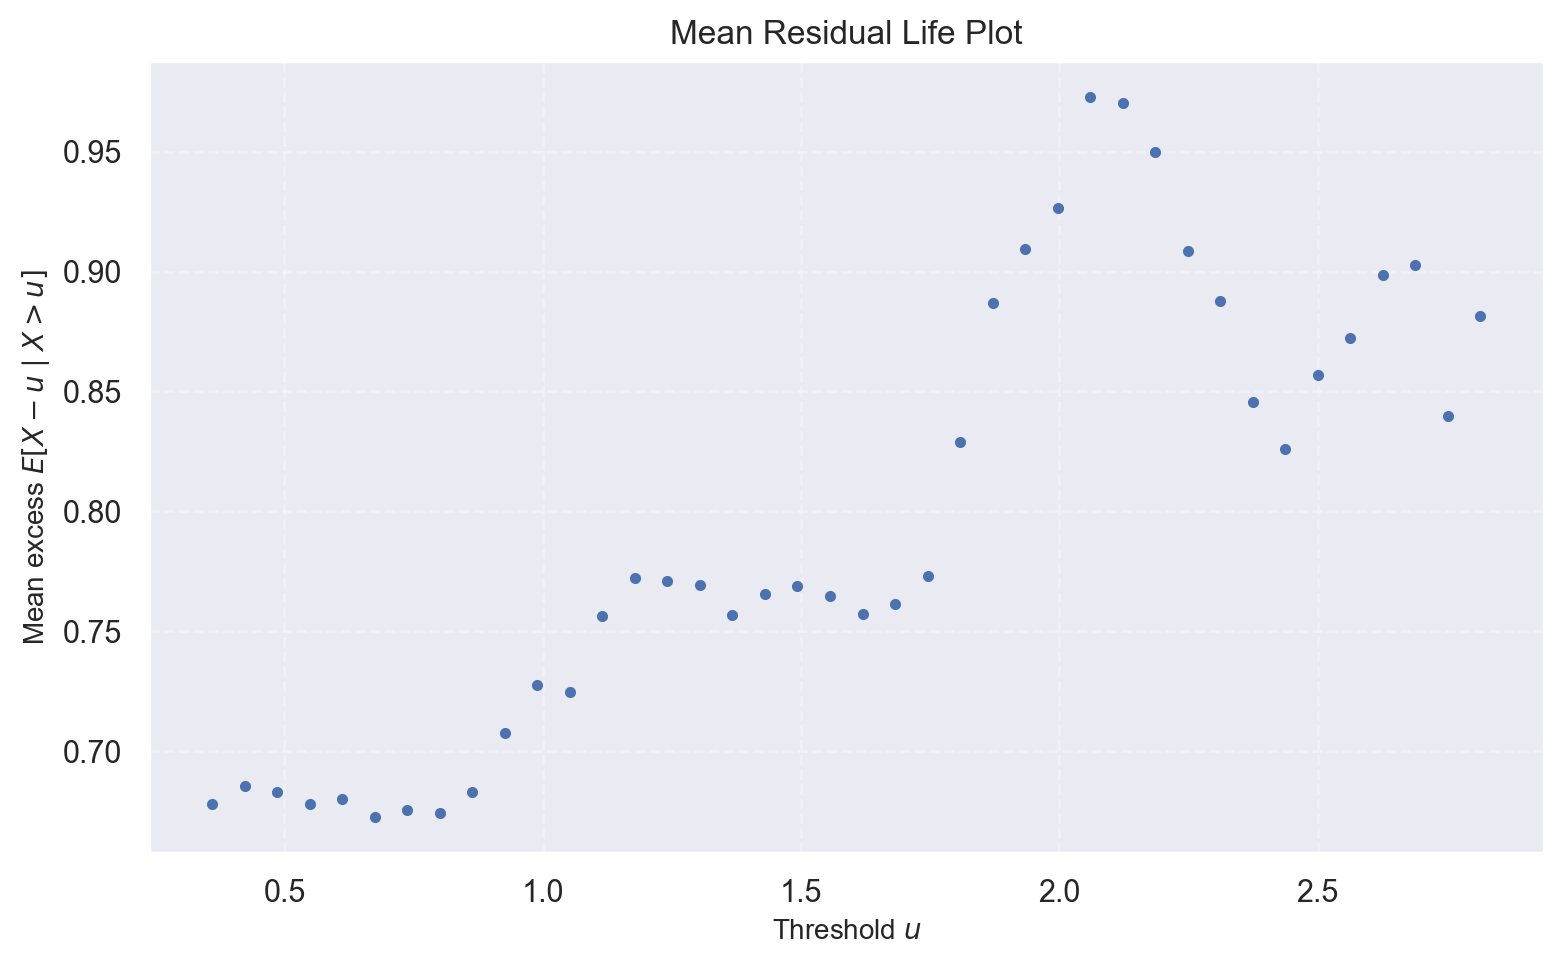

In [200]:
from scipy.stats import genpareto, kstest

sns.set_theme()

resid = res.std_resid.dropna()


# Choose a grid of thresholds in the upper tail
thresholds = np.linspace(resid.quantile(0.70), resid.quantile(0.99), 40)
mean_excess = []

for u in thresholds:
    excess = resid[resid > u] - u
    mean_excess.append(excess.mean())

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(thresholds, mean_excess, marker="o", linestyle="none", markersize=3)

ax.set_title("Mean Residual Life Plot", fontsize=12)
ax.set_xlabel("Threshold $u$", fontsize=10)
ax.set_ylabel("Mean excess $E[X-u \mid X>u]$", fontsize=10)

ax.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig("MRL_plot.pdf", format="pdf", dpi=300)
plt.show()


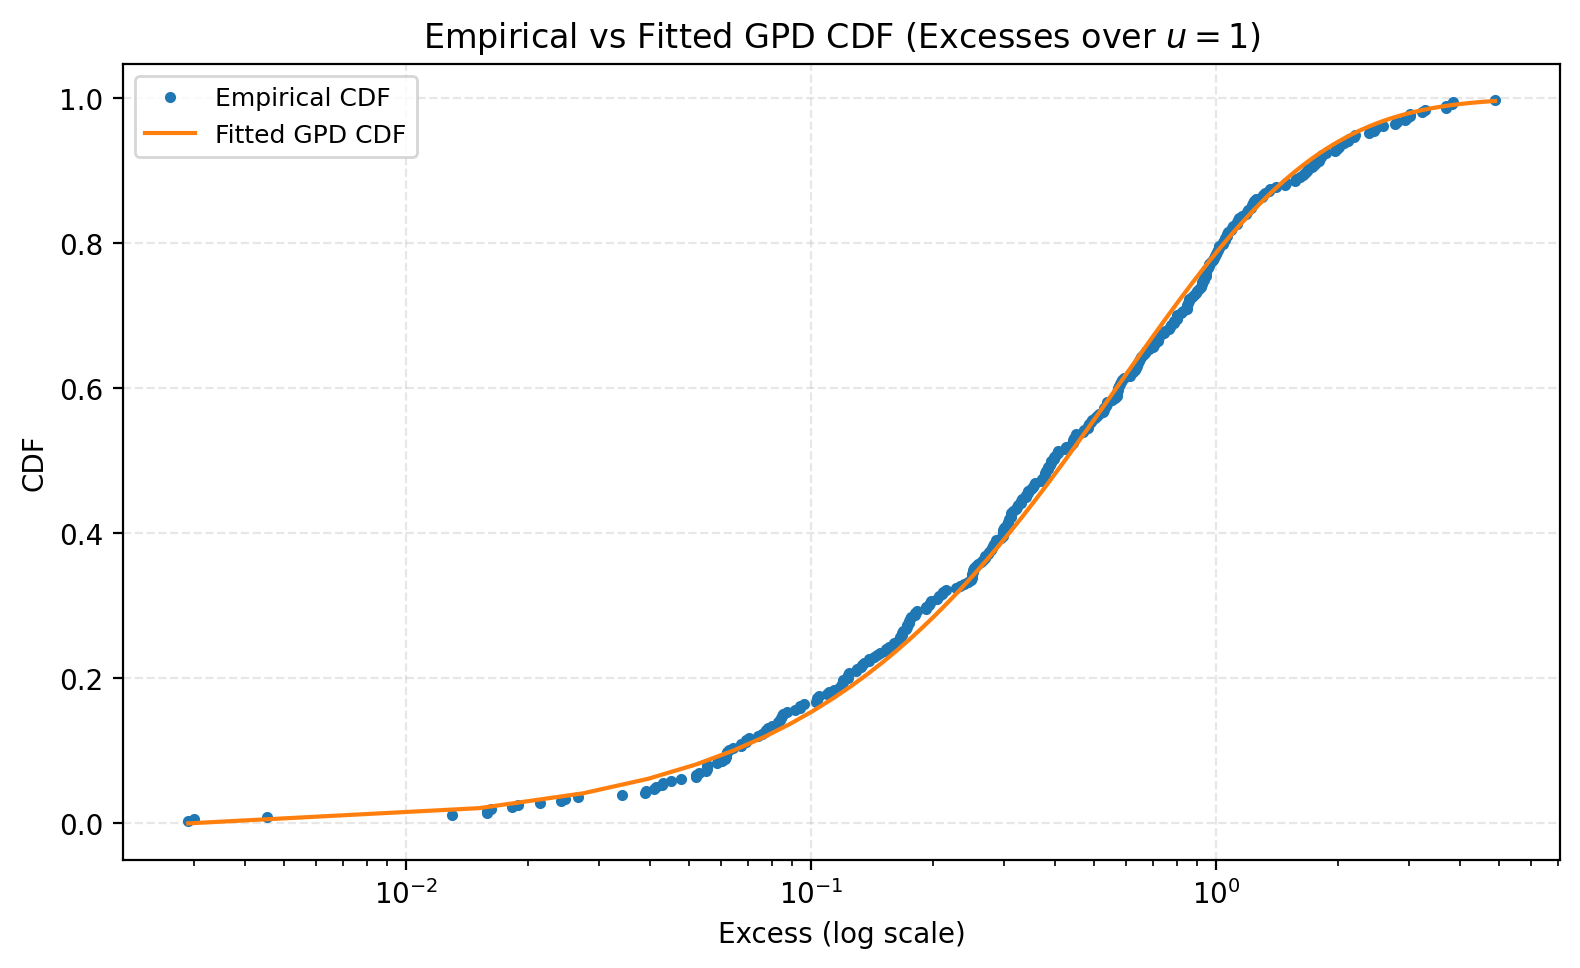

In [114]:



u = 0.8  # chosen threshold
excess = resid[resid > u] - u

# Fit Generalized Pareto Distribution
params = genpareto.fit(excess)
GPD_shape, GPD_loc, GPD_scale = params


sorted_excess = np.sort(excess)
n = len(sorted_excess)
emp_cdf = np.arange(1, n + 1) / (n + 1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(sorted_excess, emp_cdf, marker="o", linestyle="none", markersize=3,
        label="Empirical CDF")

x = np.linspace(sorted_excess.min(), sorted_excess.max(), 400)
ax.plot(
    x,
    genpareto.cdf(x, GPD_shape, loc=GPD_loc, scale=GPD_scale),
    linewidth=1.5,
    label="Fitted GPD CDF",
)

ax.set_xscale("log")
ax.set_title("Empirical vs Fitted GPD CDF (Excesses over $u=1$)", fontsize=12)
ax.set_xlabel("Excess (log scale)", fontsize=10)
ax.set_ylabel("CDF", fontsize=10)

ax.legend(fontsize=9)
ax.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.savefig("GPD_cdf_fit.pdf", format="pdf", dpi=300)
plt.show()

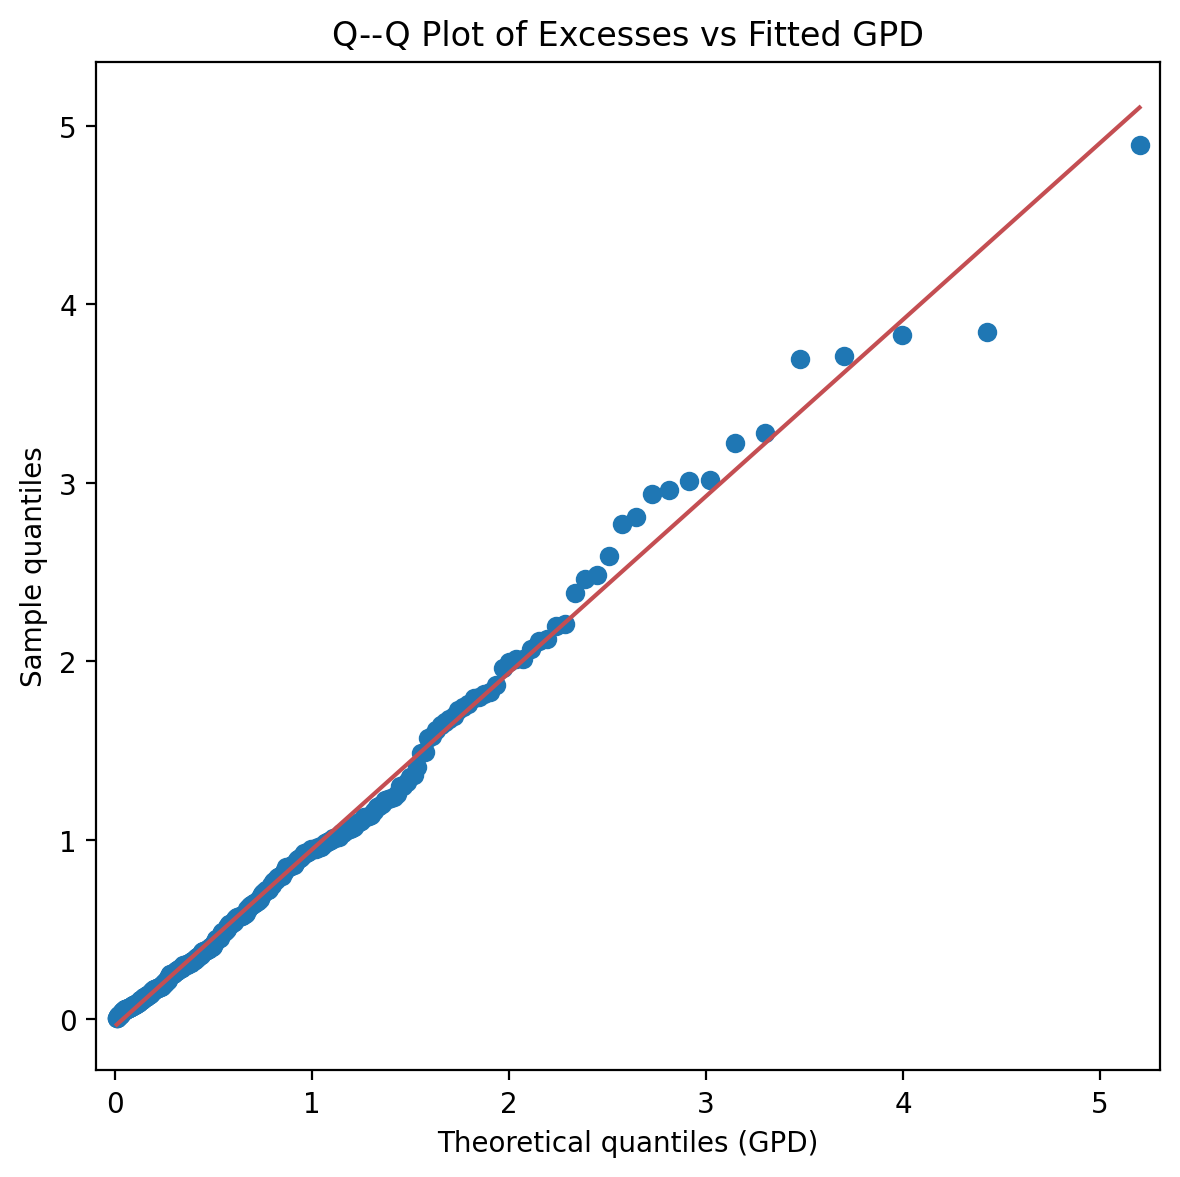

In [162]:
# Freeze the fitted GPD to avoid loc/scale conflicts
fitted_gpd = genpareto(c=GPD_shape, loc=GPD_loc, scale=GPD_scale)

fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(excess, dist=fitted_gpd, line="r", ax=ax)

ax.set_title("Q--Q Plot of Excesses vs Fitted GPD", fontsize=12)
ax.set_xlabel("Theoretical quantiles (GPD)", fontsize=10)
ax.set_ylabel("Sample quantiles", fontsize=10)

plt.tight_layout()
plt.savefig("GPD_qqplot.pdf", format="pdf", dpi=300)
plt.show()

In [116]:

ks_statistic, p_value = kstest(excess, "genpareto", args=params)
print(f"KS statistic: {ks_statistic:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.0313, p-value: 0.8634


In [117]:
GPD_shape, GPD_loc, GPD_scale

(np.float64(0.14463279570888207),
 np.float64(0.0029034598518321493),
 np.float64(0.5766588739886194))

In [118]:
thresholds = res.std_resid.sort_values().to_list()
x = []
excess_means = []
for thresh in thresholds:
    excess_df = res.std_resid[res.std_resid>thresh]-thresh
    nb_excess = excess_df.count()
    excess_mean = excess_df.sum()/nb_excess if nb_excess>0 else None
    if len(excess_means)>0 and excess_mean!=excess_means[-1]:
        excess_means.append(excess_mean)
        x.append(thresh)
    elif len(excess_means)==0:
        excess_means.append(excess_mean)
        x.append(thresh)

C:\Users\ilias\AppData\Local\Temp\ipykernel_44856\995912475.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


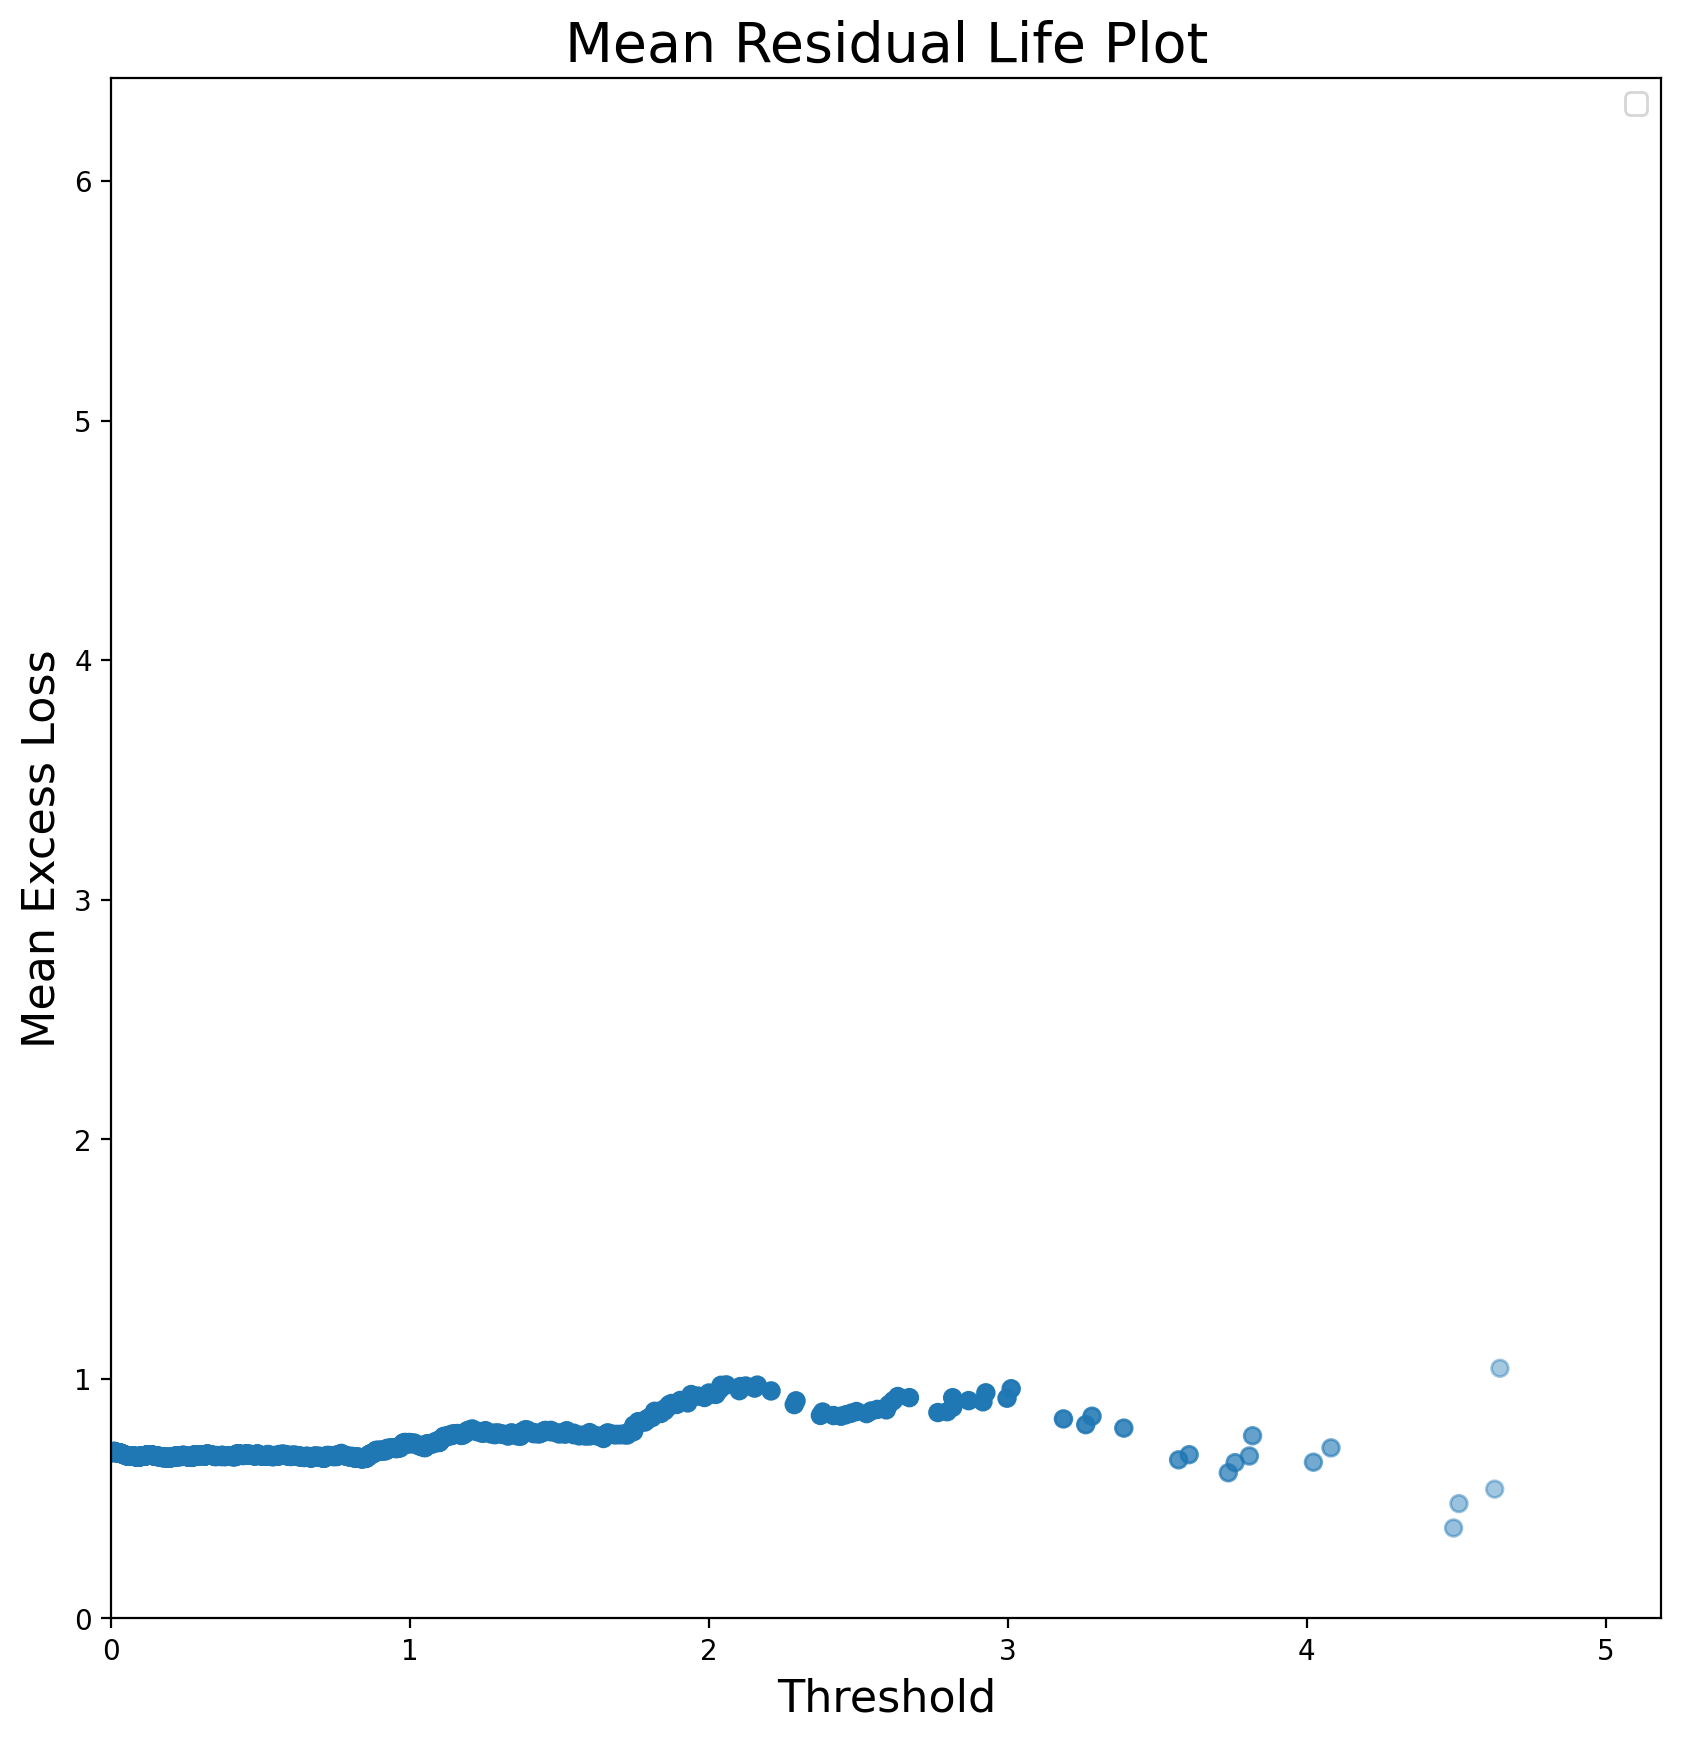

In [119]:
fig, ax = plt.subplots(figsize=(10, 10))

x = np.array(x)
threshold = 2.9
alphas = np.ones_like(x)
mask = x > threshold
alphas[mask] = 1 - (x[mask] - threshold) / (x.max() - threshold) * (1 - 0.05)

plt.scatter(x, excess_means, alpha=alphas)



plt.legend()
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Mean Excess Loss', fontsize=16)
plt.title('Mean Residual Life Plot', fontsize=20)
plt.ylim(0)
plt.xlim(0)
plt.show()

There seems to be two linear tendencies on the mean excess plot. We want to have a linear trend after a certain threshold u. This threshold is set at u=1, as we can see on the graph above the mean excess loss is fairly linear, except for some extremity points. 

In [120]:
u = 1
excess_df = res.std_resid[res.std_resid>u]-u


In [121]:
from scipy.stats import genpareto
params = genpareto.fit(excess_df)

In [122]:
GPD_shape, GPD_loc, GPD_scale  = params

In [123]:
params

(np.float64(0.09590251139262831),
 np.float64(0.005259443915181105),
 np.float64(0.657726450221837))

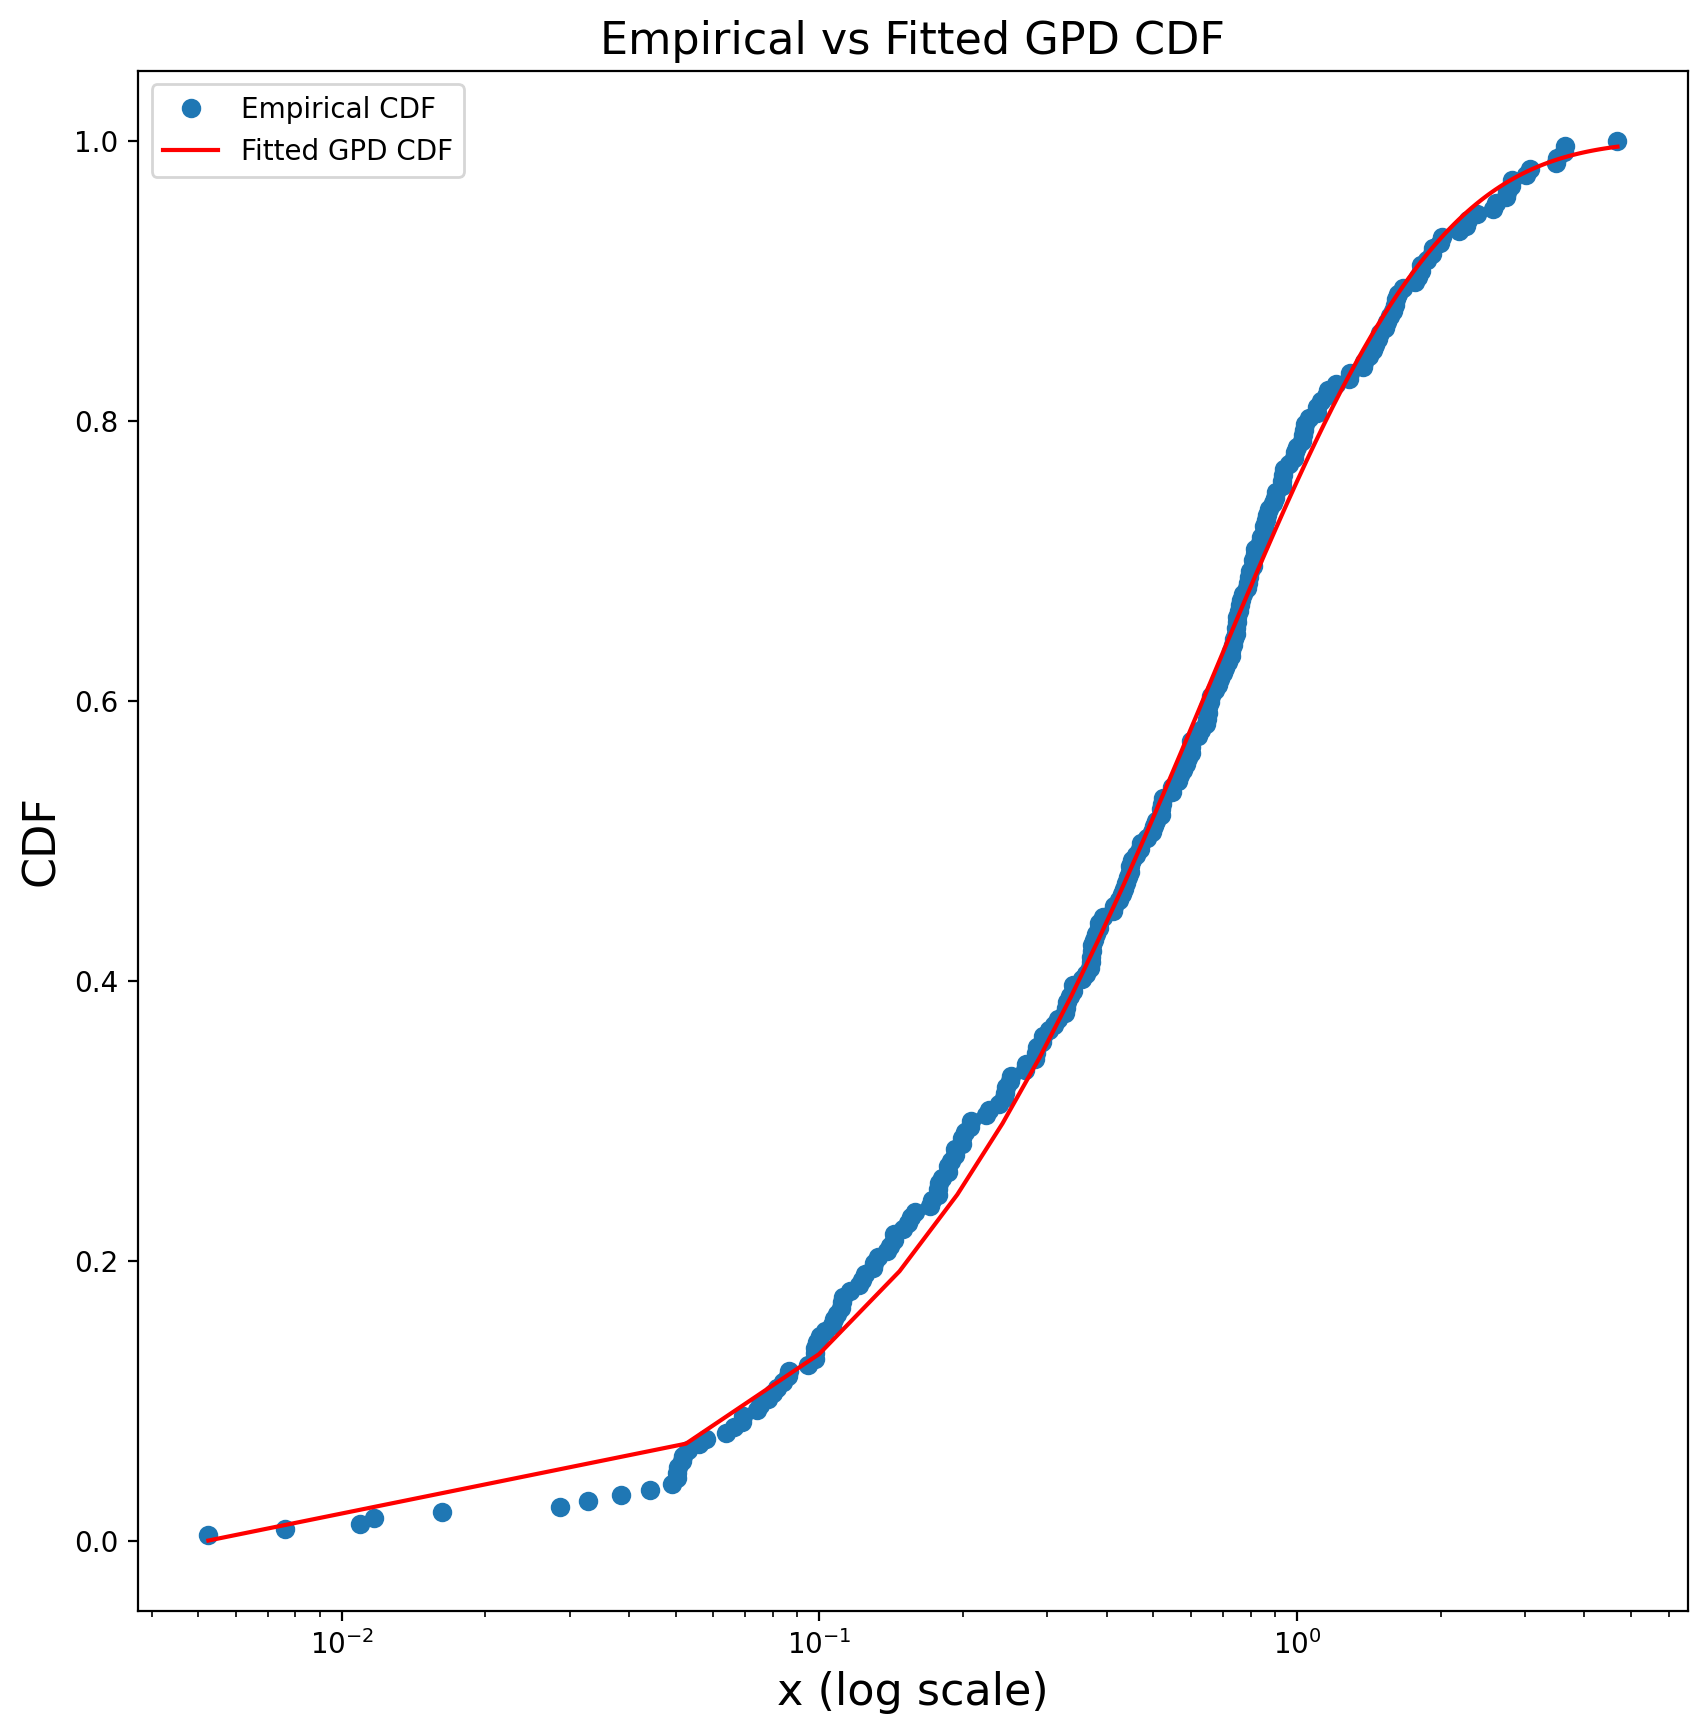

In [124]:
sorted = excess_df.sort_values().reset_index(drop=True)
cdf_values = []
for i in range(len(excess_df)):
        cdf_value = np.sum(sorted <= sorted[i]) / len(excess_df)
        cdf_values.append(cdf_value)


plt.figure(figsize=(10, 10))
plt.plot(np.sort(excess_df), cdf_values, marker='o', linestyle='', label='Empirical CDF')
x = np.linspace(min(excess_df), max(excess_df), 100)
plt.plot(x, genpareto.cdf(x, params[0], params[1], params[2]), label='Fitted GPD CDF', color='red')
plt.legend()
plt.gca().set_xscale('log', base=10)
plt.title("Empirical vs Fitted GPD CDF", fontsize=16)
plt.xlabel("x (log scale)", fontsize=16)
plt.ylabel("CDF", fontsize=16)
plt.show()

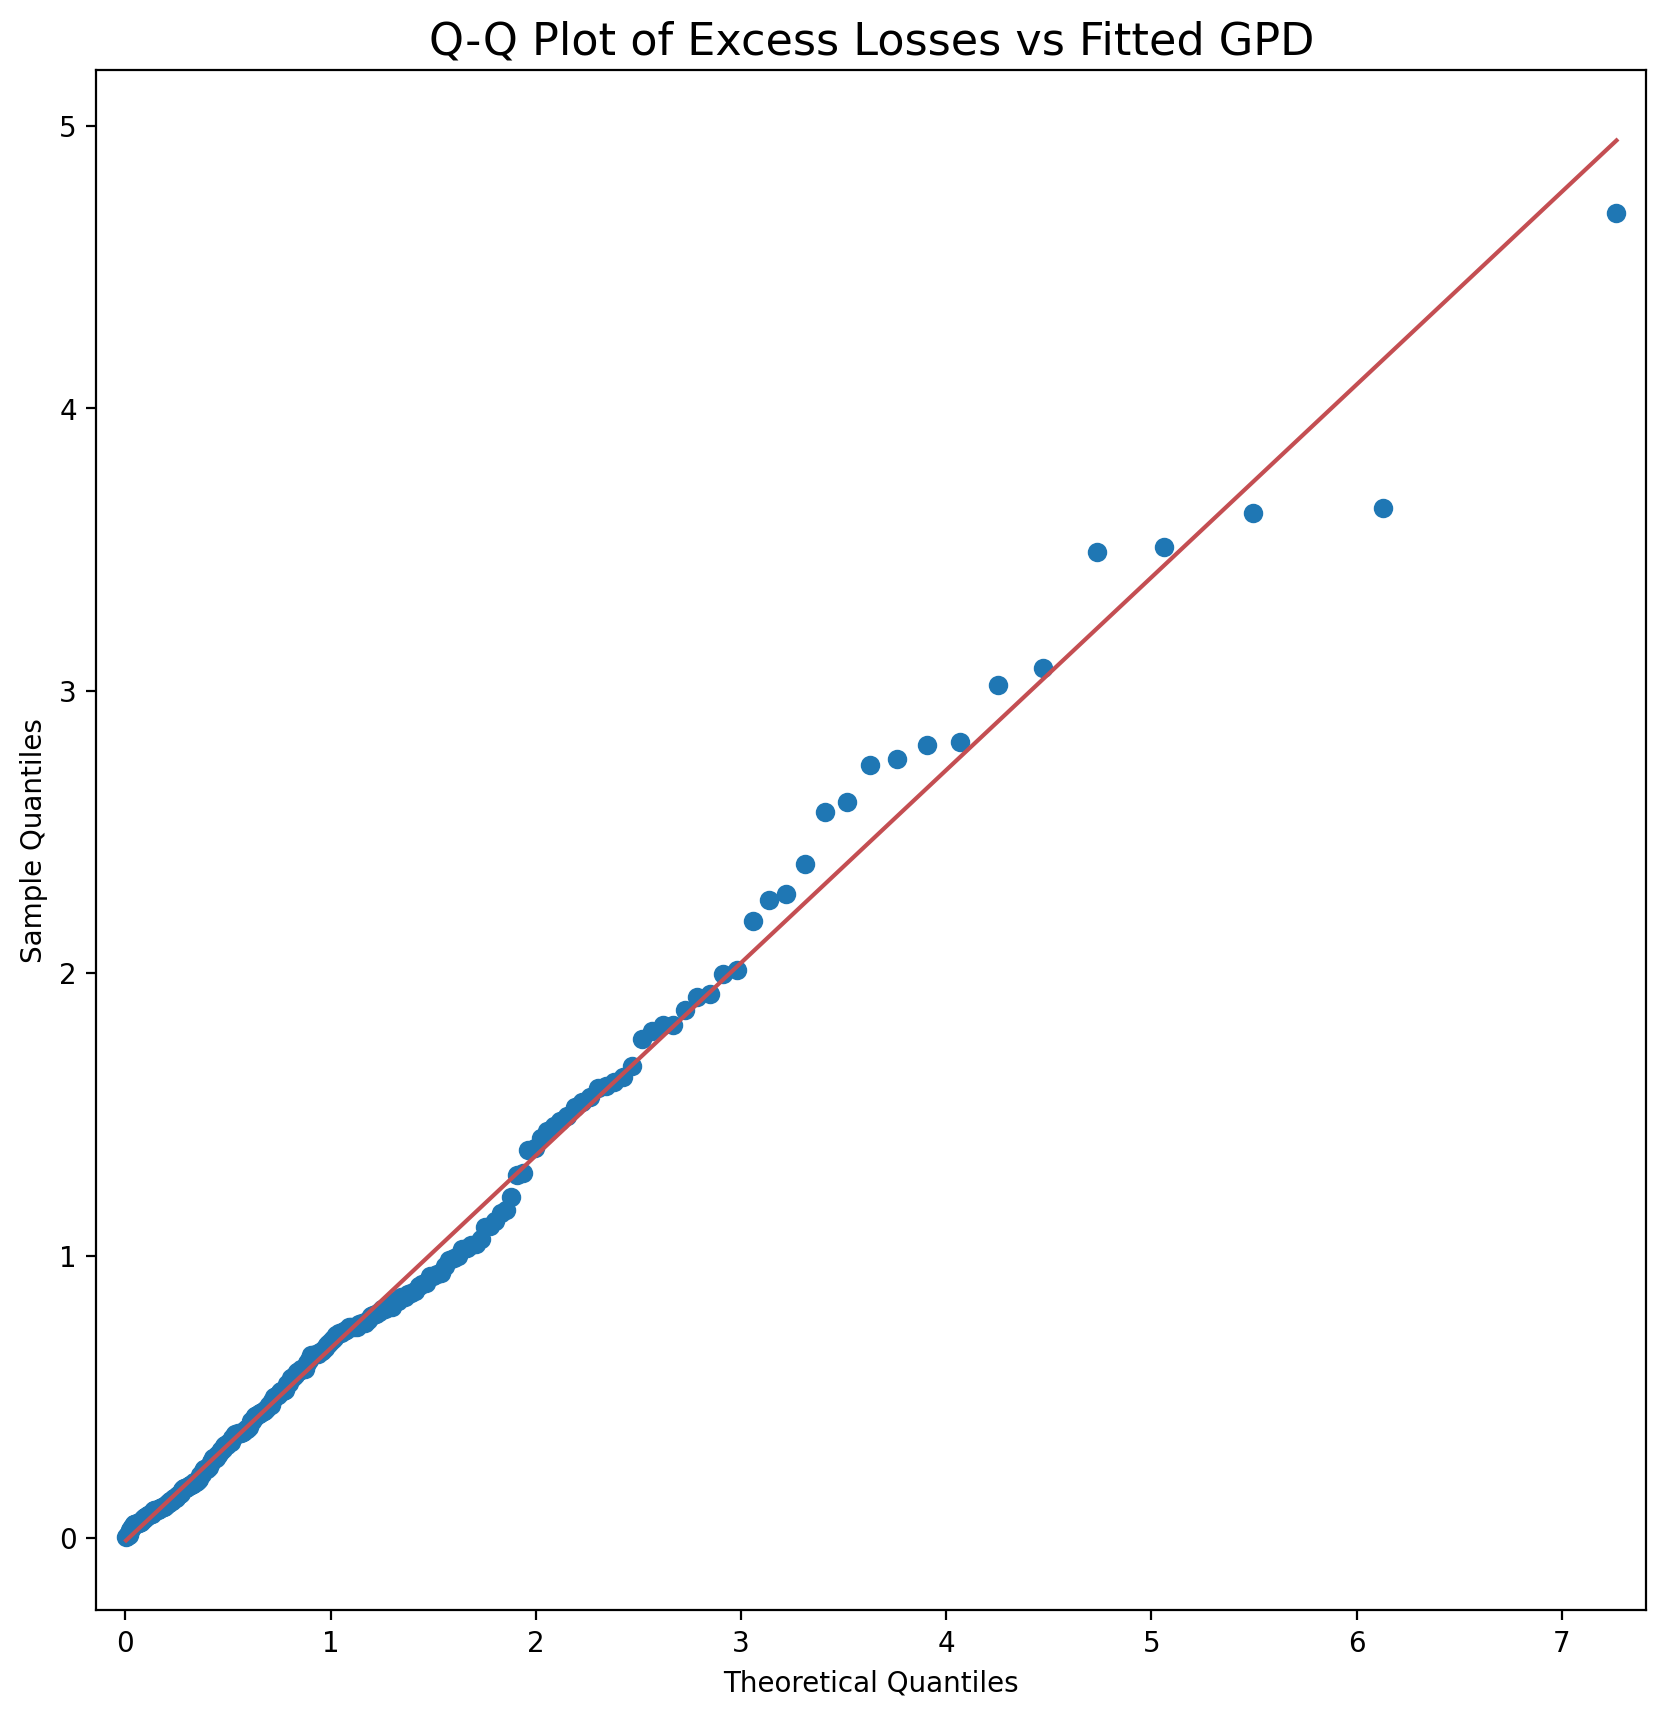

In [125]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(excess_df, dist=genpareto, distargs=(params[0],), ax=ax, line='r')
plt.title('Q-Q Plot of Excess Losses vs Fitted GPD', fontsize=16)
plt.show()

In [126]:
from scipy.stats import kstest
ks_statistic, p_value = kstest(excess_df, 'genpareto', args=params)
alpha = 0.05
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than {alpha}, so we reject the null hypothesis.")
    print("The data does not appear to follow a Generalized Pareto Distribution with the estimated parameters.")
else:
    print(f"The p-value ({p_value:.4f}) is greater than {alpha}, so we fail to reject the null hypothesis.")
    print("The data appears to follow a Generalized Pareto Distribution with the estimated parameters.")

The p-value (0.8575) is greater than 0.05, so we fail to reject the null hypothesis.
The data appears to follow a Generalized Pareto Distribution with the estimated parameters.


## VaR with GARCH(1,1) and normal innovations

Fitting the model on train data

In [127]:
Garch_normal = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='normal')
res = Garch_normal.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109978.16287170455
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948164452209
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970838471652
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.871427110367
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501807425867
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.2480692428735
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7989571706585
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.349726412105
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254455983
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119614499
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900477
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900477
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations:

In [128]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Thu, Dec 04 2025   Df Residuals:                     2265
Time:                        11:09:14   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1506  6.417e-02     -2.347  1.892e-02 [ -0.2

In [129]:
preds = res.forecast(horizon=len(test_df))
mus = preds.mean.squeeze()
sigmas = np.sqrt(preds._residual_variance.squeeze())

In [130]:
stats.norm.ppf(0.95)
stats.norm.ppf(0.99)

np.float64(2.3263478740408408)

In [131]:
mus.index = test_df.Date
sigmas.index = test_df.Date

compute VaR

In [132]:
test_df['mus'], test_df['sigmas'] = mus.values, sigmas.values
test_df['VaR95'] = test_df['mus'] + test_df['sigmas']*stats.norm.ppf(0.95)
test_df['VaR99'] = test_df['mus'] + test_df['sigmas']*stats.norm.ppf(0.99)

### Compute ES
formula part 2 p.58, phi functions defined p.52 as pdf, cdf

In [133]:
test_df['ES95'] = test_df['mus'] + (test_df['sigmas']*stats.norm.pdf(stats.norm.ppf(0.05)))/0.05
test_df['ES99'] = test_df['mus'] + (test_df['sigmas']*stats.norm.pdf(stats.norm.ppf(0.01)))/0.01

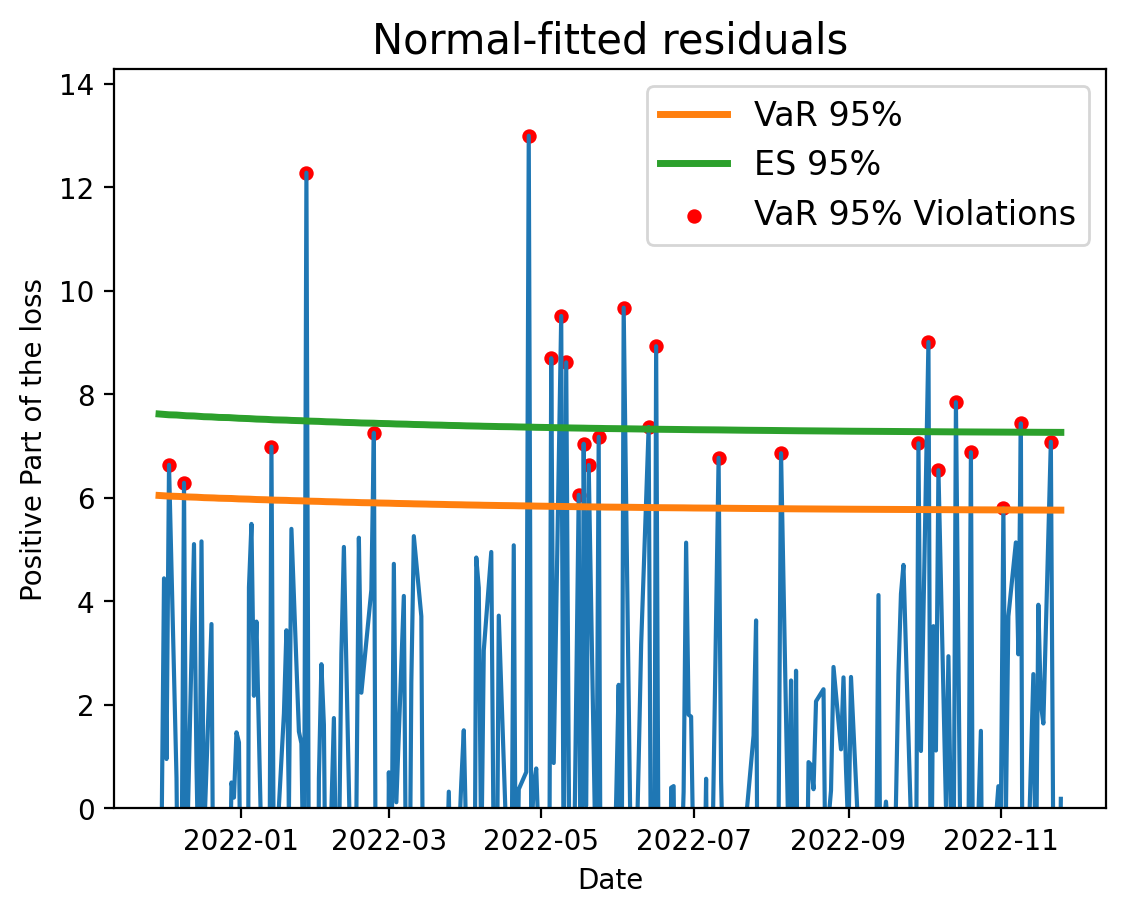

In [183]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95'], label='VaR 95%', linewidth=2.5)
plt.plot(test_df.Date, test_df['ES95'], label='ES 95%', linewidth=2.5)

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations', s=70)
plt.legend(fontsize=12)
plt.title('Normal-fitted residuals', fontsize=15)
plt.savefig("95VaRn.pdf", format="pdf", dpi=300)
plt.show()


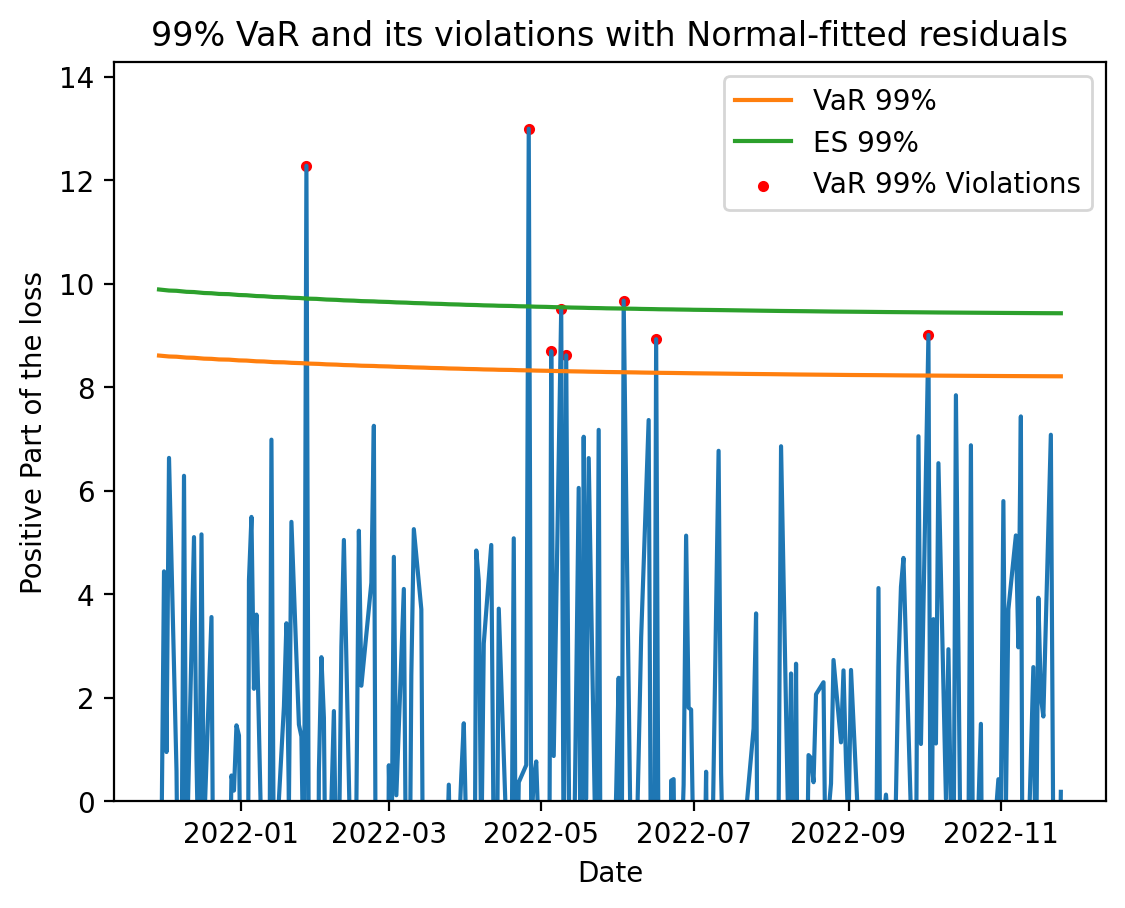

In [135]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR99'], label='VaR 99%')
plt.plot(test_df.Date, test_df['ES99'], label='ES 99%')

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR99']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 99% Violations')
plt.legend()
plt.title('99% VaR and its violations with Normal-fitted residuals')
plt.show()


## GARCH(1,1) with standardized t-student innovations

In [136]:
Garch_t = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='t')
res = Garch_t.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 53371.352146943726
Iteration:      2,   Func. Count:     15,   Neg. LLF: 58997.98097858561
Iteration:      3,   Func. Count:     24,   Neg. LLF: 9431.709641118323
Iteration:      4,   Func. Count:     33,   Neg. LLF: 7222.229544737593
Iteration:      5,   Func. Count:     40,   Neg. LLF: 6372.323110099656
Iteration:      6,   Func. Count:     47,   Neg. LLF: 7406.850345038201
Iteration:      7,   Func. Count:     54,   Neg. LLF: 5681.15991522212
Iteration:      8,   Func. Count:     61,   Neg. LLF: 5678.134784996288
Iteration:      9,   Func. Count:     68,   Neg. LLF: 7216.559309612435
Iteration:     10,   Func. Count:     75,   Neg. LLF: 5673.940748269164
Iteration:     11,   Func. Count:     81,   Neg. LLF: 5673.900396840992
Iteration:     12,   Func. Count:     87,   Neg. LLF: 5673.898055619298
Iteration:     13,   Func. Count:     93,   Neg. LLF: 5673.89792896886
Iteration:     14,   Func. Count:     99,   Neg. LLF: 5673.897906

In [137]:
res

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         loss   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5673.90
Distribution:      Standardized Student's t   AIC:                           11357.8
Method:                  Maximum Likelihood   BIC:                           11386.4
                                              No. Observations:                 2266
Date:                      Thu, Dec 04 2025   Df Residuals:                     2265
Time:                              11:09:15   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

In [138]:
df = res.params['nu']

In [139]:
preds = res.forecast(horizon=len(test_df))
must = preds.mean.squeeze()
sigmast = np.sqrt(preds._residual_variance.squeeze())

In [140]:
scale_std = np.sqrt((df - 2.0) / df)
q95 = stats.t.ppf(0.95, df=df, scale=1, loc=0)*scale_std
q99 = stats.t.ppf(0.99, df=df, scale=1, loc=0)*scale_std


### computing VaR

In [141]:
test_df['must'], test_df['sigmast'] = must.values, sigmast.values
test_df['VaR95t'] = test_df['must'] + test_df['sigmast']*q95
test_df['VaR99t'] = test_df['must'] + test_df['sigmast']*q99

### computing ES
formula part 2 p.58, phi functions defined p.52 as pdf, cdf adapted to the t-student distrib

In [142]:
test_df['ES95t'] = test_df['must'] + (test_df['sigmast']*stats.t.pdf(q95, df, loc=0, scale=1))/0.05
test_df['ES99t'] = test_df['must'] + (test_df['sigmast']*stats.t.pdf(q99, df, loc=0, scale=1))/0.01

In [143]:
test_df.head()

,Date,TSLA,log_returns,loss,mus,sigmas,VaR95,VaR99,ES95,ES99,must,sigmast,VaR95t,VaR99t,ES95t,ES99t,VaR95GPD,VaR99GPD,ES95GPD,ES99GPD
2268,2021-11-29,378.996674,4.964716,-4.964716,-0.150609,3.766584,6.044870,8.611775,7.618771,9.888143,-0.185897,3.878946,5.489578,10.126738,9.684194,11.736555,5.620705,10.266655,7.600109,12.246059
2269,2021-11-30,381.586670,0.681058,-0.681058,-0.150609,3.764631,6.041658,8.607233,7.614744,9.882940,-0.185897,3.882577,5.494890,10.136390,9.693432,11.747715,5.617714,10.261255,7.596092,12.239634
2270,2021-12-01,365.000000,-4.444065,4.444065,-0.150609,3.762699,6.038480,8.602738,7.610759,9.877790,-0.185897,3.886176,5.500157,10.145960,9.702591,11.758778,5.614753,10.255912,7.592116,12.233275
2271,2021-12-02,361.533325,-0.954313,0.954313,-0.150609,3.760787,6.035335,8.598290,7.606814,9.872694,-0.185897,3.889745,5.505378,10.155447,9.711671,11.769747,5.611823,10.250623,7.588181,12.226981
2272,2021-12-03,338.323334,-6.635217,6.635217,-0.150609,3.758895,6.032222,8.593887,7.602911,9.867650,-0.185897,3.893283,5.510555,10.164854,9.720674,11.780621,5.608923,10.245389,7.584287,12.220752


### plots

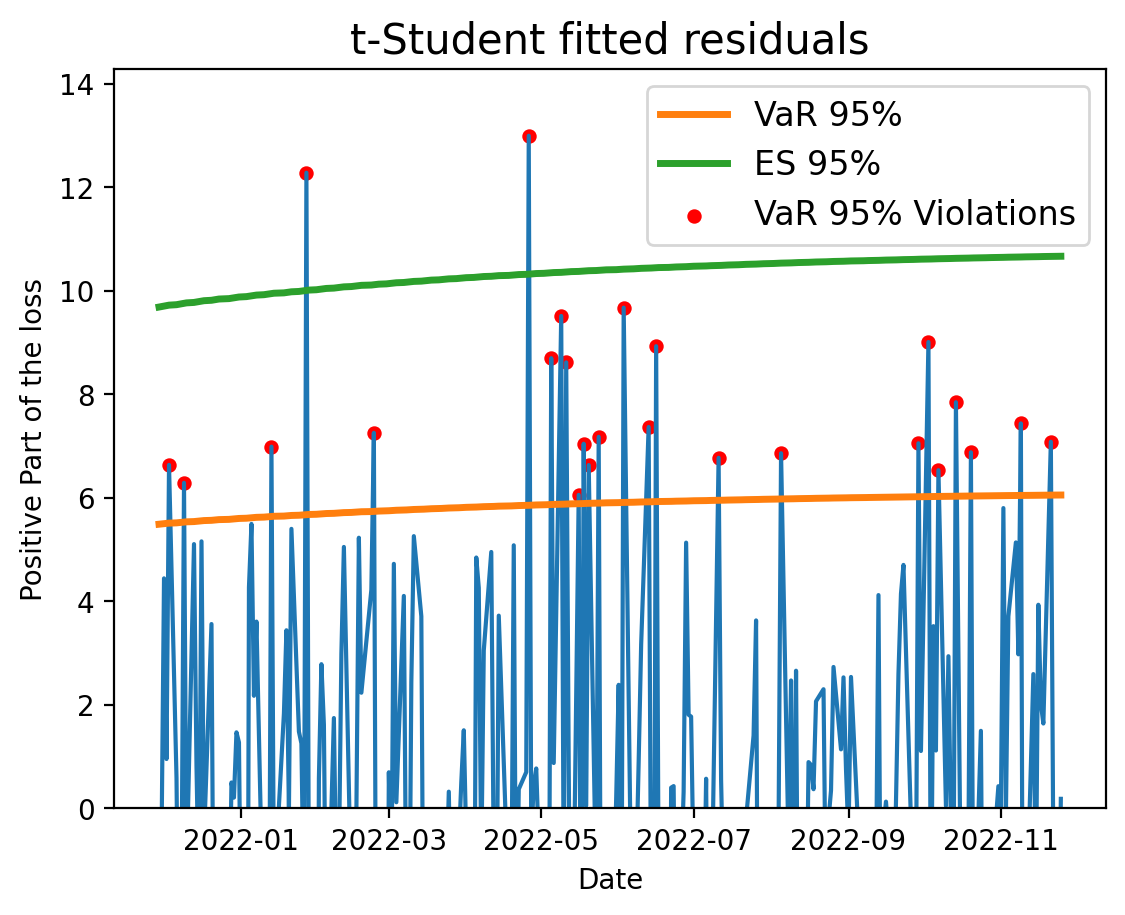

In [187]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95t'], label='VaR 95%', linewidth=2.5)
plt.plot(test_df.Date, test_df['ES95t'], label='ES 95%', linewidth=2.5)

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95t']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations', s=70)
plt.legend(fontsize=12)
plt.title('t-Student fitted residuals', fontsize=15)
plt.savefig('95VaRt.pdf')
plt.show()


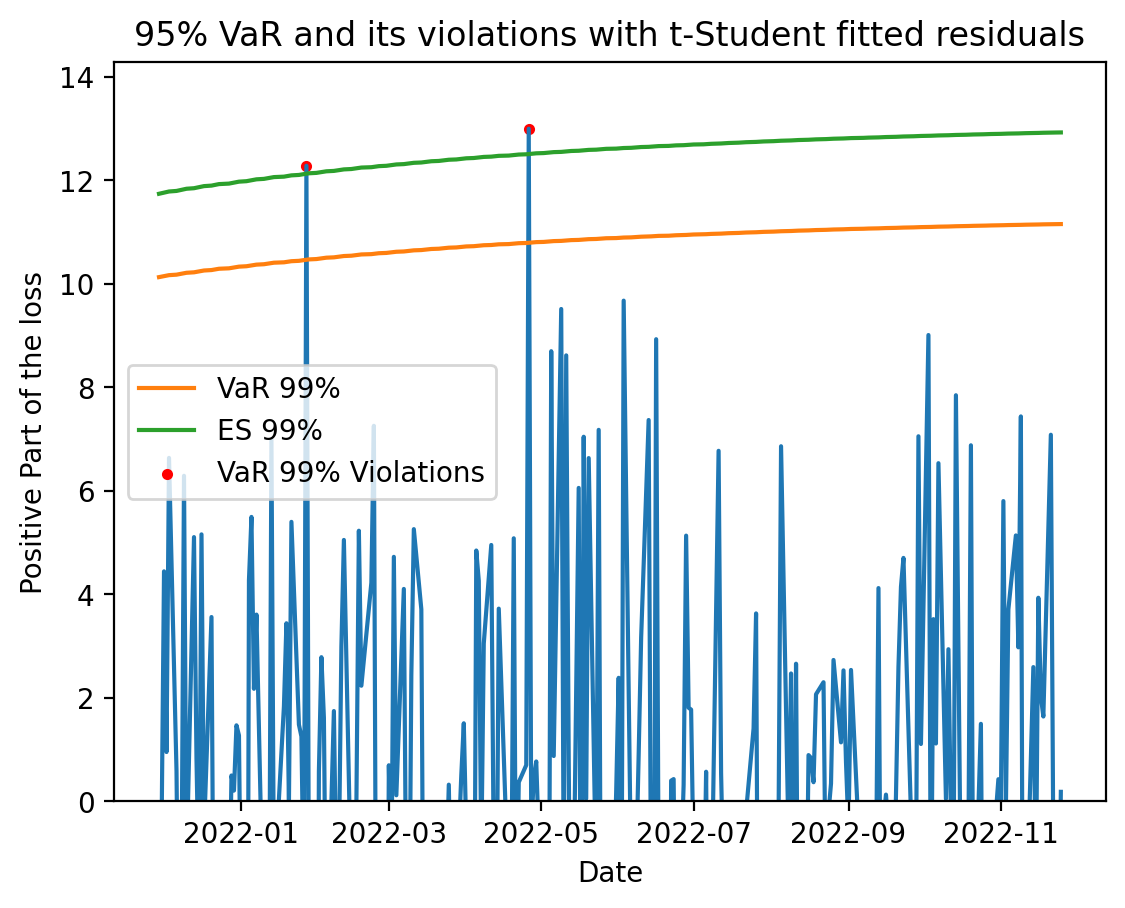

In [145]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR99t'], label='VaR 99%')
plt.plot(test_df.Date, test_df['ES99t'], label='ES 99%')

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR99t']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 99% Violations')
plt.legend()
plt.title('95% VaR and its violations with t-Student fitted residuals')
plt.show()


## GPD model of excess values

In [146]:
Garch_normal = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='normal')
res = Garch_normal.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109978.16287170455
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948164452209
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970838471652
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.871427110367
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501807425867
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.2480692428735
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7989571706585
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.349726412105
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254455983
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119614499
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900477
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900477
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations:

In [147]:
preds = res.forecast(horizon=len(test_df))
mus = preds.mean.squeeze()
sigmas = np.sqrt(preds._residual_variance.squeeze())

In [148]:
from statsmodels.distributions.empirical_distribution import ECDF

zeta, beta = GPD_shape, GPD_scale
ecdf = ECDF(res.std_resid)
F_u = ecdf(u)
print(F_u)

0.8909973521624007


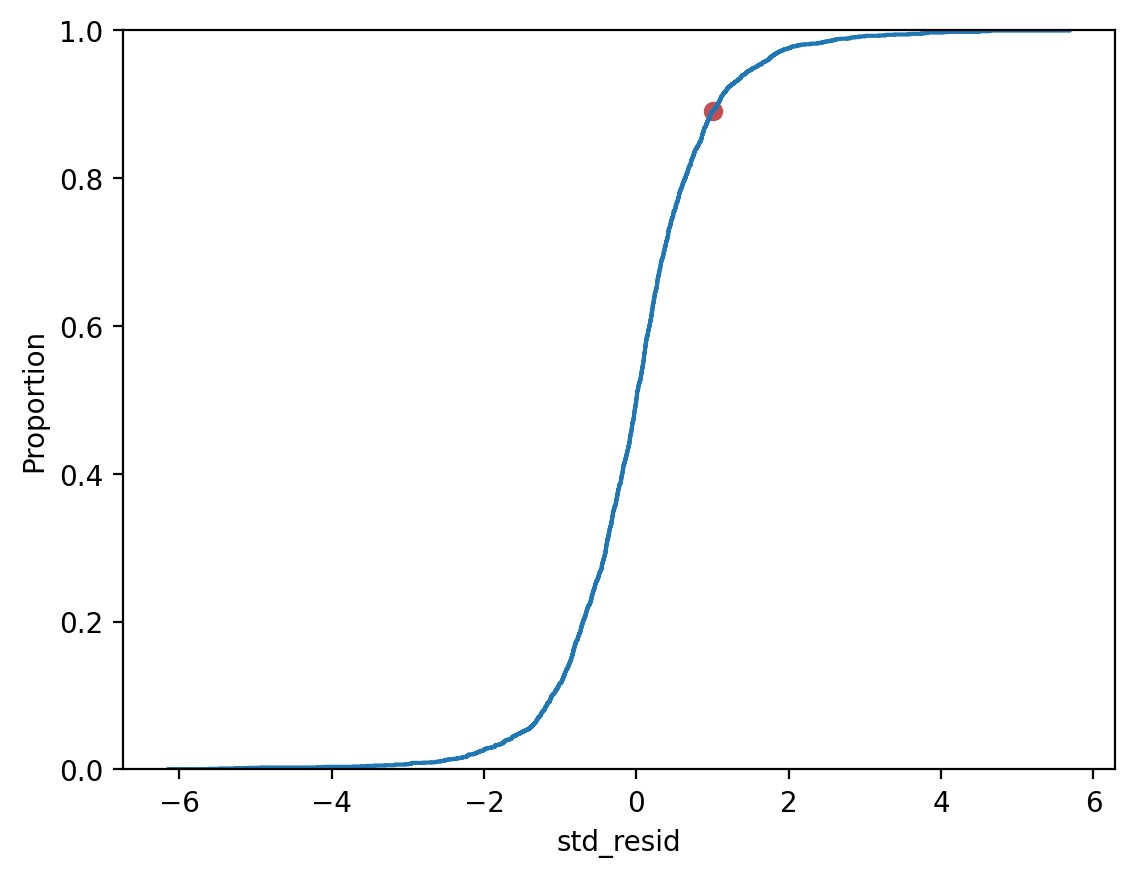

In [149]:
#check if the F_u is the correct value
sns.ecdfplot(res.std_resid)
plt.scatter(u, F_u, color='r')
plt.show()

### compute VaR

In [150]:
q95GPD = (u + ((beta/zeta) * ((((1-0.95)/(1-F_u))**(-zeta))  -1 )))
q99GPD = (u + ((beta/zeta) * ((((1-0.99)/(1-F_u))**(-zeta))  -1 )))

test_df['VaR95GPD'] = test_df['mus'] + test_df['sigmas']*q95GPD
test_df['VaR99GPD'] = test_df['mus'] + test_df['sigmas']*q99GPD

### compute ER

formula used slide 61, part 4
<br>
we used mus/sigmas from fitted GARCH(1,1) with Normal innovations as it is stated in part4, slide 53

In [151]:
test_df['ES95GPD'] = test_df['mus'] + test_df['sigmas']*((q95GPD/1-zeta)+((beta-zeta*u)/(1-zeta)))
test_df['ES99GPD'] = test_df['mus'] + test_df['sigmas']*((q99GPD/1-zeta)+((beta-zeta*u)/(1-zeta)))

In [152]:
beta

np.float64(0.657726450221837)

In [153]:
test_df.head()

,Date,TSLA,log_returns,loss,mus,sigmas,VaR95,VaR99,ES95,ES99,must,sigmast,VaR95t,VaR99t,ES95t,ES99t,VaR95GPD,VaR99GPD,ES95GPD,ES99GPD
2268,2021-11-29,378.996674,4.964716,-4.964716,-0.150609,3.766584,6.044870,8.611775,7.618771,9.888143,-0.185897,3.878946,5.489578,10.126738,9.684194,11.736555,5.620705,10.266655,7.600109,12.246059
2269,2021-11-30,381.586670,0.681058,-0.681058,-0.150609,3.764631,6.041658,8.607233,7.614744,9.882940,-0.185897,3.882577,5.494890,10.136390,9.693432,11.747715,5.617714,10.261255,7.596092,12.239634
2270,2021-12-01,365.000000,-4.444065,4.444065,-0.150609,3.762699,6.038480,8.602738,7.610759,9.877790,-0.185897,3.886176,5.500157,10.145960,9.702591,11.758778,5.614753,10.255912,7.592116,12.233275
2271,2021-12-02,361.533325,-0.954313,0.954313,-0.150609,3.760787,6.035335,8.598290,7.606814,9.872694,-0.185897,3.889745,5.505378,10.155447,9.711671,11.769747,5.611823,10.250623,7.588181,12.226981
2272,2021-12-03,338.323334,-6.635217,6.635217,-0.150609,3.758895,6.032222,8.593887,7.602911,9.867650,-0.185897,3.893283,5.510555,10.164854,9.720674,11.780621,5.608923,10.245389,7.584287,12.220752


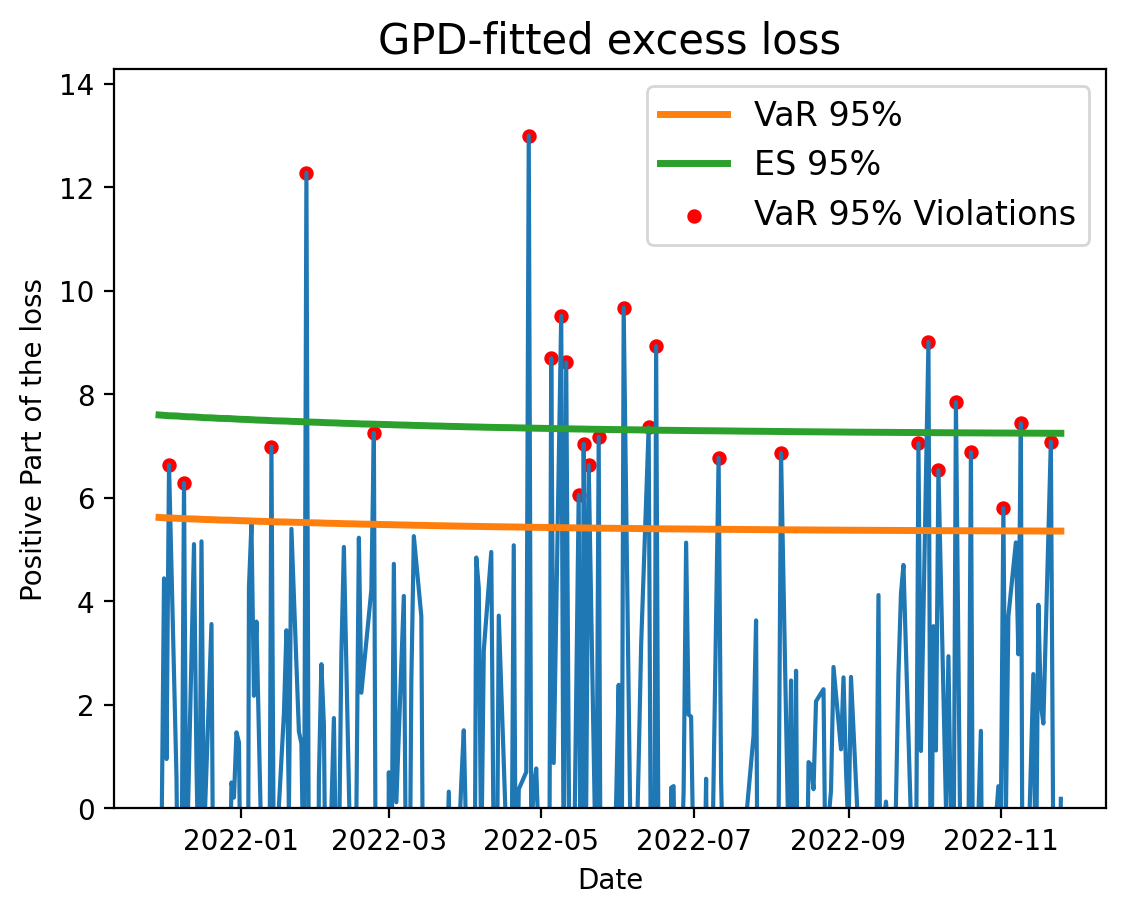

In [189]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95GPD'], label='VaR 95%', linewidth=2.5)
plt.plot(test_df.Date, test_df['ES95GPD'], label='ES 95%', linewidth=2.5)
plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95GPD']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations', s=70)
plt.legend(fontsize=12)
plt.title('GPD-fitted excess loss', fontsize=15)
plt.savefig('95VaRGPD.pdf')
plt.show()


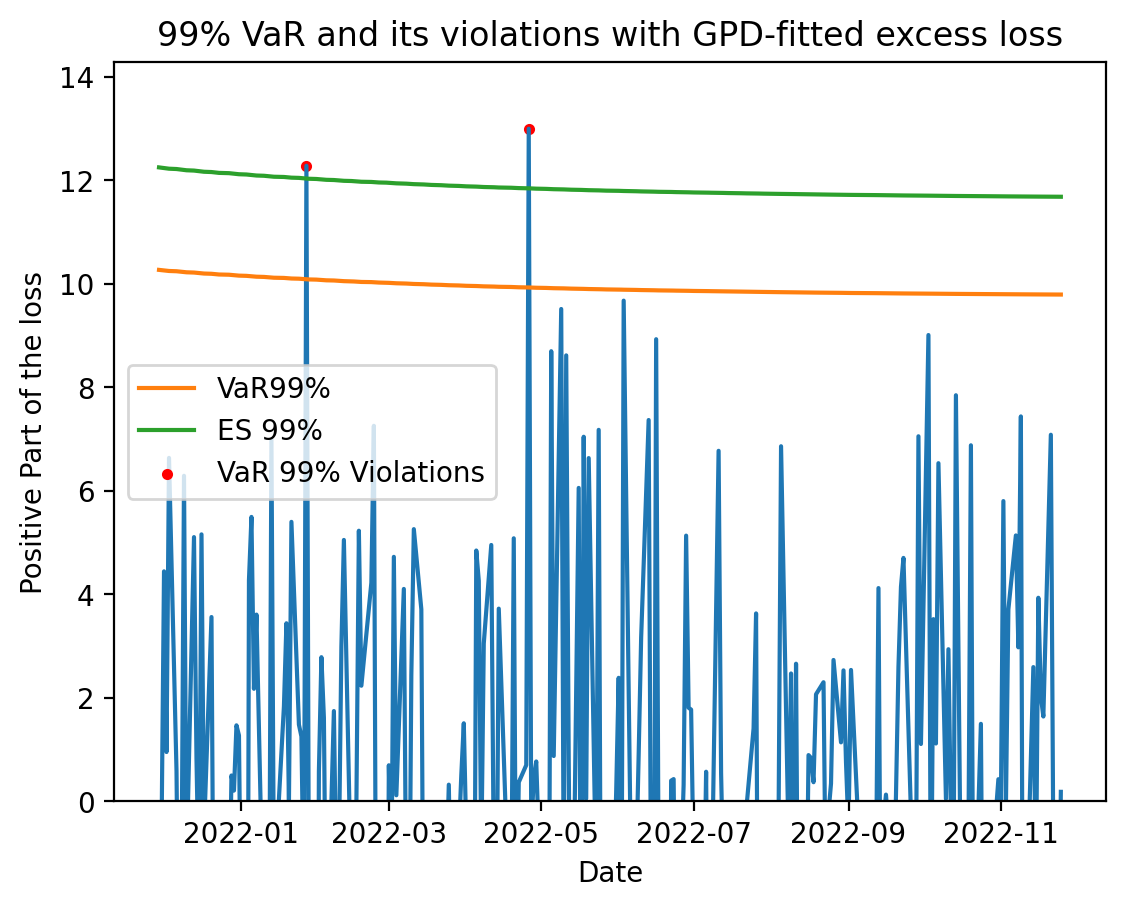

In [155]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR99GPD'], label='VaR99%')
plt.plot(test_df.Date, test_df['ES99GPD'], label='ES 99%')

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR99GPD']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 99% Violations')
plt.legend()
plt.title('99% VaR and its violations with GPD-fitted excess loss')
plt.show()


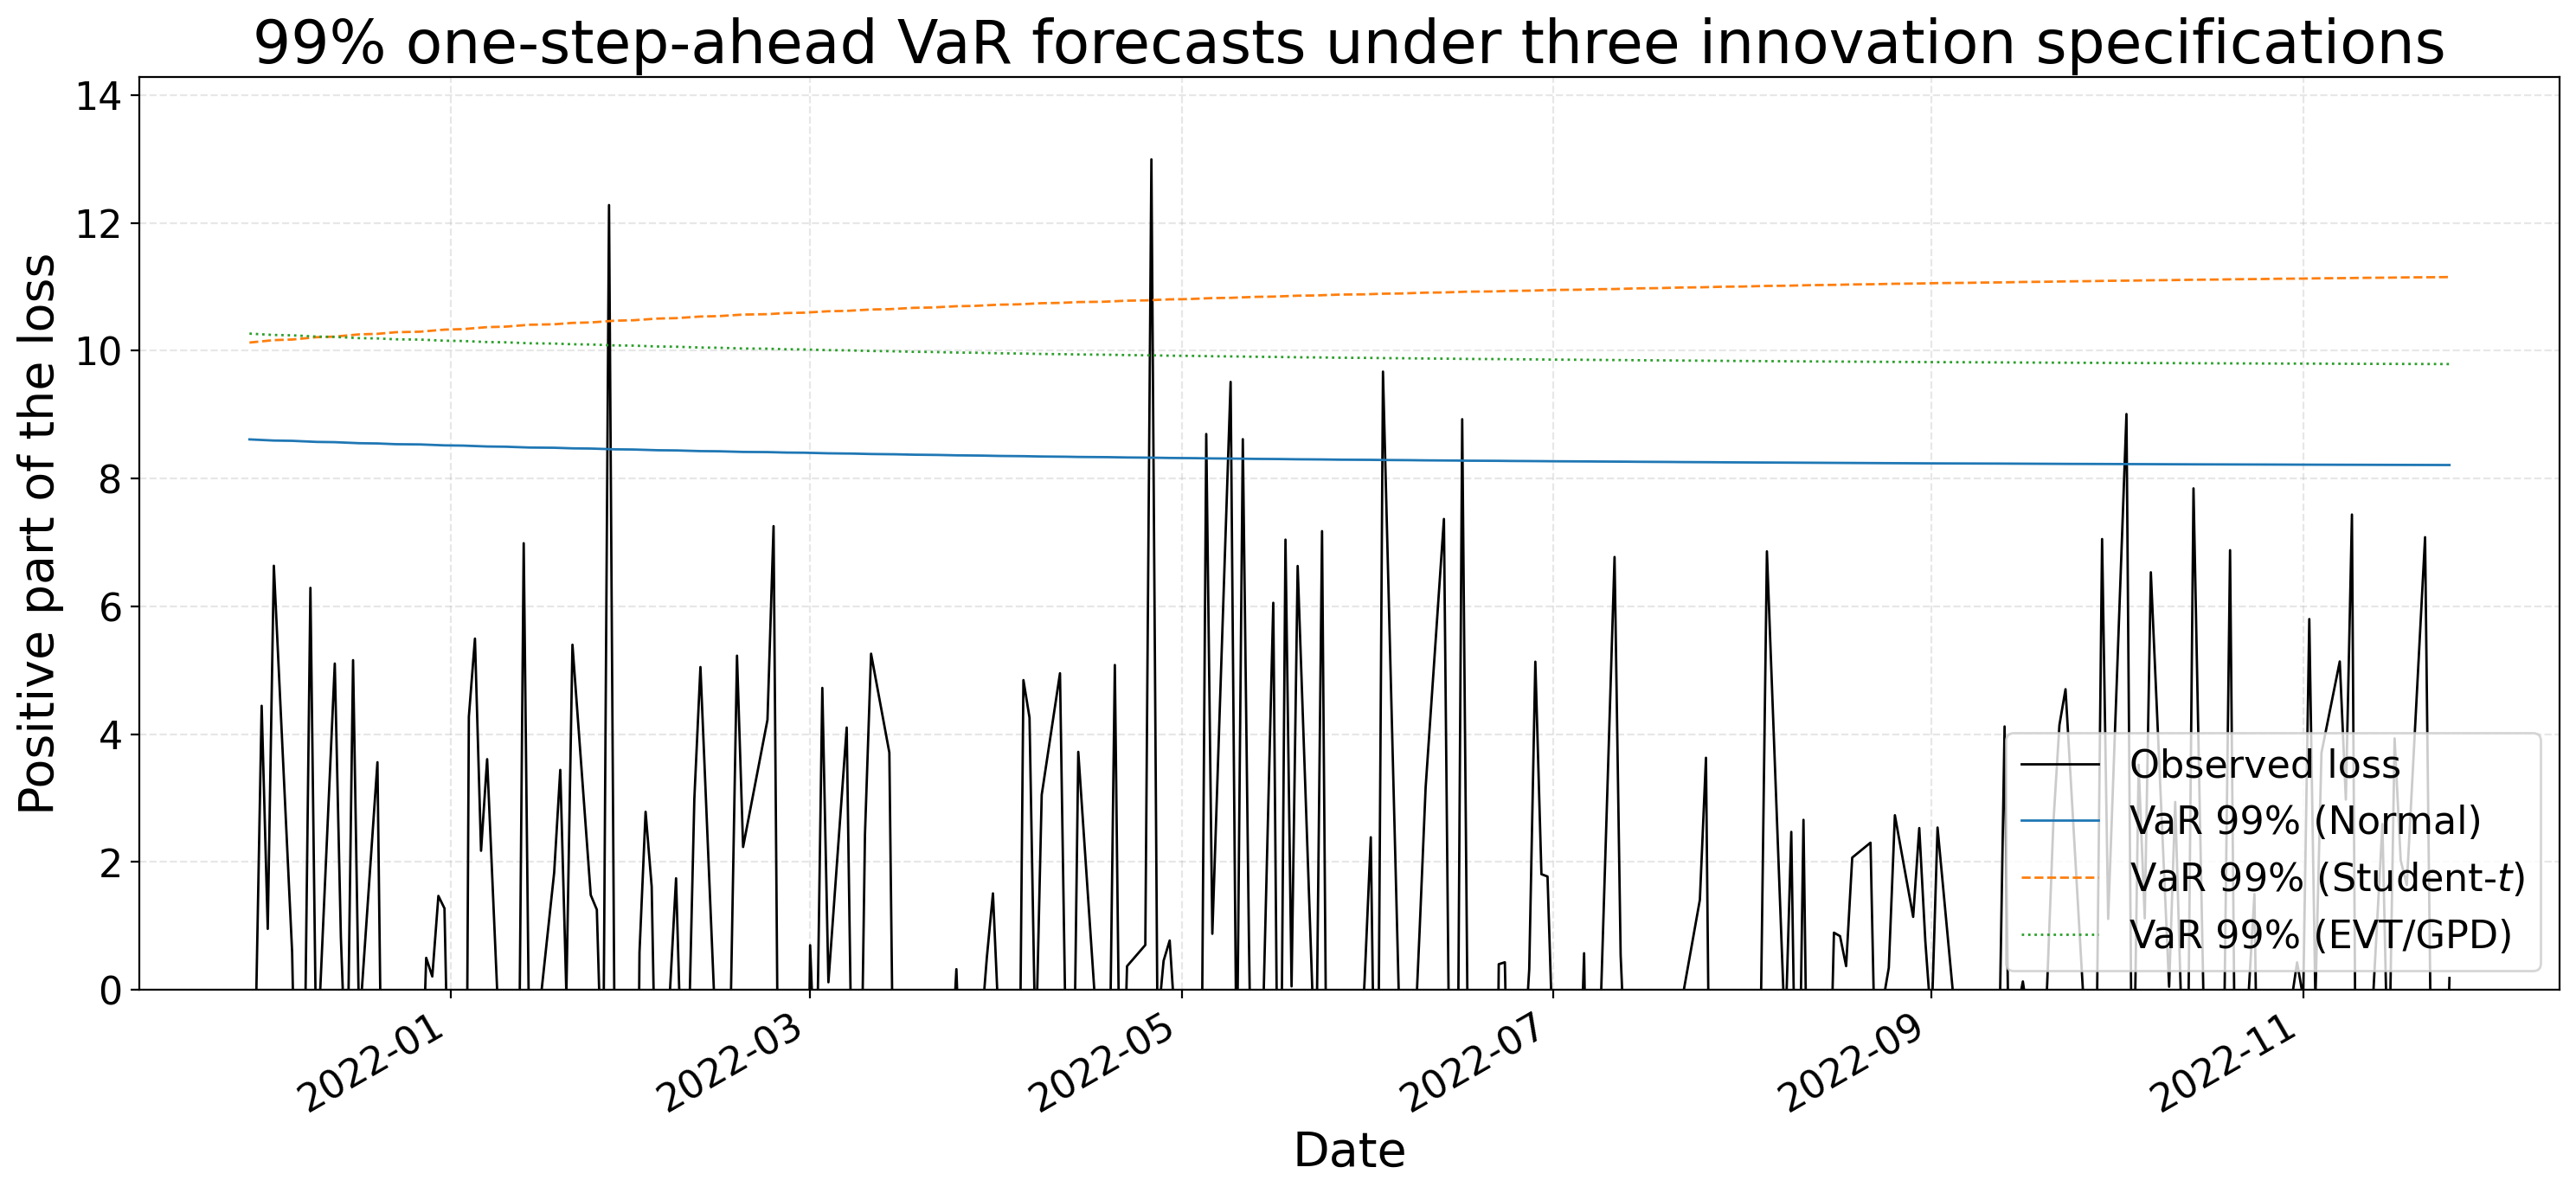

In [170]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    test_df["Date"],
    test_df["loss"],
    label="Observed loss",
    color="black",
    linewidth=1,
)

ax.plot(
    test_df["Date"],
    test_df["VaR99"],
    label="VaR 99% (Normal)",
    linewidth=1,
)
ax.plot(
    test_df["Date"],
    test_df["VaR99t"],
    label="VaR 99% (Student-$t$)",
    linewidth=1,
    linestyle="--",
)
ax.plot(
    test_df["Date"],
    test_df["VaR99GPD"],
    label="VaR 99% (EVT/GPD)",
    linewidth=1,
    linestyle=":",
)

ax.set_ylim(0)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("Positive part of the loss", fontsize=20)
ax.set_title(
    "99% one-step-ahead VaR forecasts under three innovation specifications",
    fontsize=25,
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Axe des dates propre
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()

ax.grid(alpha=0.3, linestyle="--")
ax.legend(fontsize=16)

fig.tight_layout()
fig.savefig("VaR_99_allmodels.pdf", format="pdf", dpi=300)
plt.show()

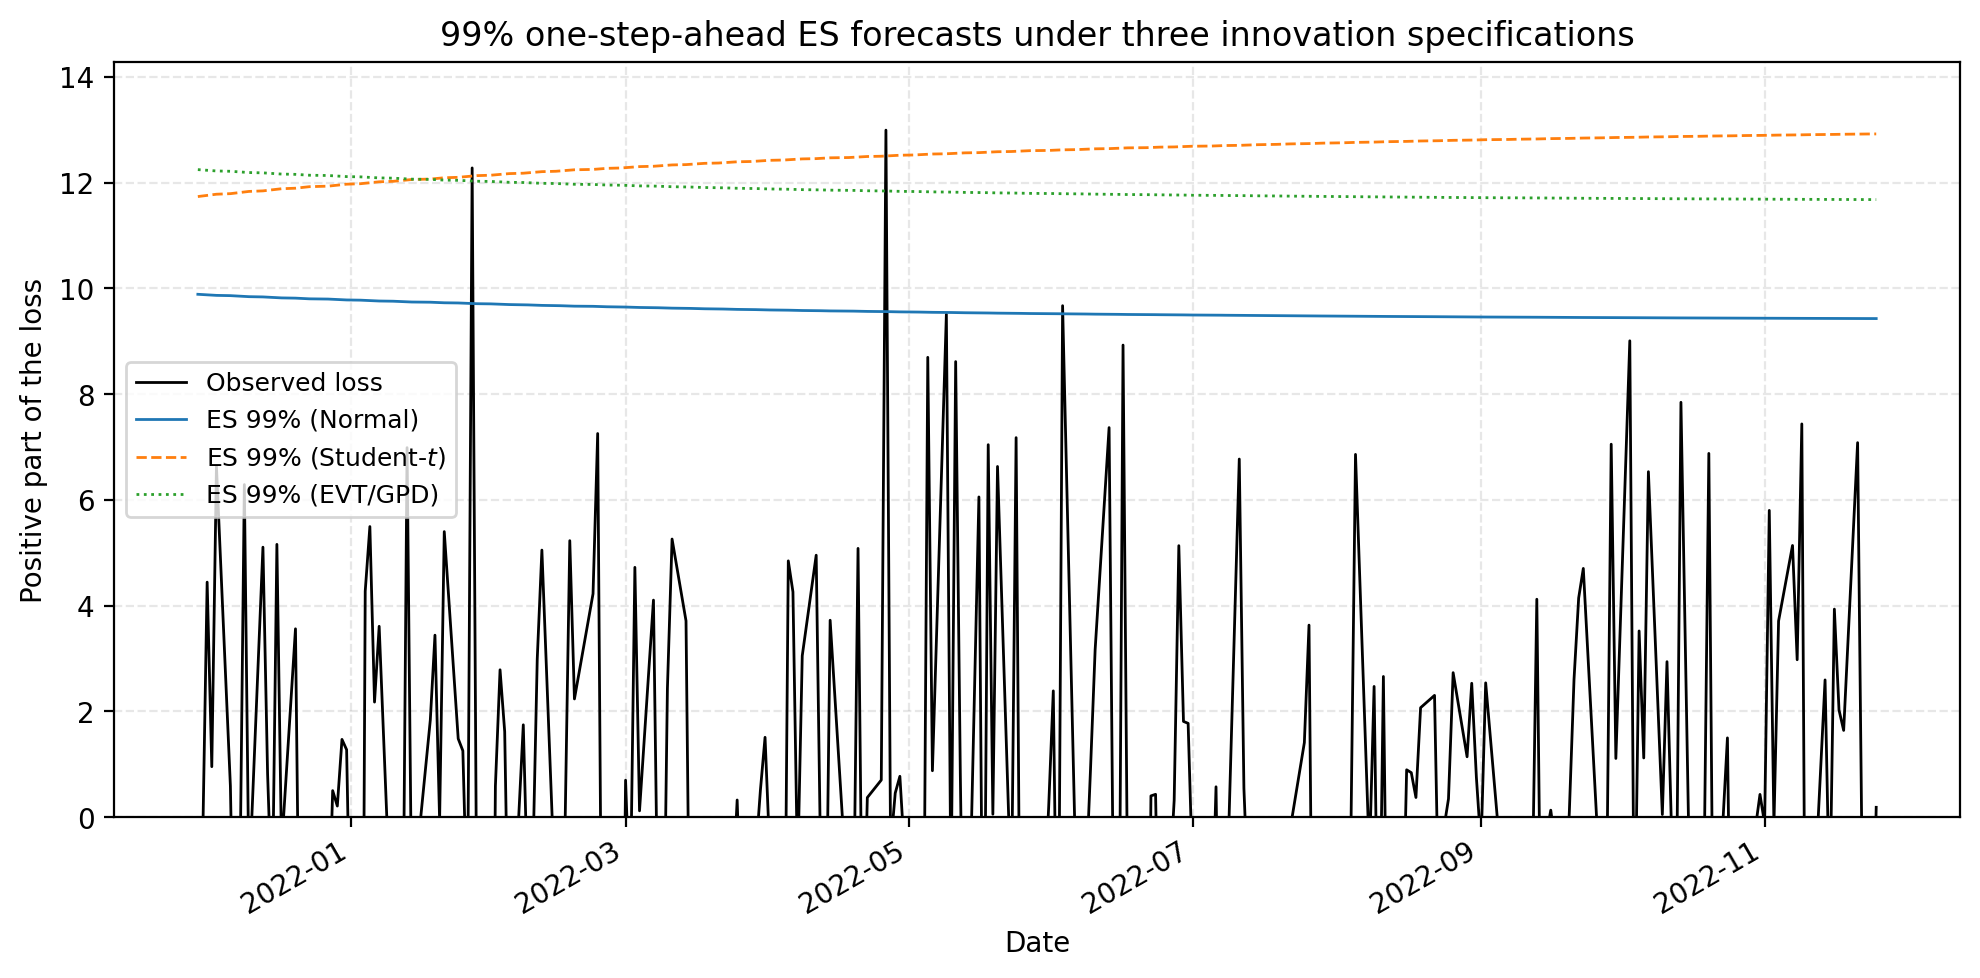

In [171]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    test_df["Date"],
    test_df["loss"],
    label="Observed loss",
    color="black",
    linewidth=1,
)

ax.plot(
    test_df["Date"],
    test_df["ES99"],
    label="ES 99% (Normal)",
    linewidth=1,
)
ax.plot(
    test_df["Date"],
    test_df["ES99t"],
    label="ES 99% (Student-$t$)",
    linewidth=1,
    linestyle="--",
)
ax.plot(
    test_df["Date"],
    test_df["ES99GPD"],
    label="ES 99% (EVT/GPD)",
    linewidth=1,
    linestyle=":",
)

ax.set_ylim(0)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel("Positive part of the loss", fontsize=10)
ax.set_title(
    "99% one-step-ahead ES forecasts under three innovation specifications",
    fontsize=12,
)

locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()

ax.grid(alpha=0.3, linestyle="--")
ax.legend(fontsize=9)

fig.tight_layout()
fig.savefig("ES_99_allmodels.pdf", format="pdf", dpi=300)
plt.show()

## Backtesting VaR

In [158]:
from scipy.stats import chi2

def kupiec_test(actual_losses, var, alpha=0.05):
    """
    Kupiec's Unconditional Coverage Test (Proportion of Failures Test)
    
    Parameters:
    - actual_losses: array-like, les pertes réalisées
    - var: array-like, les valeurs de VaR correspondantes
    - alpha: float, niveau de confiance pour VaR (ex: 0.05 pour VaR 95%)
    
    Returns:
    - LRuc: statistique de test
    - p_value: p-value du test
    """
    actual_losses = np.array(actual_losses)
    var = np.array(var)
    
    n = len(actual_losses)
    x = np.sum(actual_losses > var) 
    # theoretical proba
    p = alpha
    # empirical exceedances frequency
    p_hat = x / n
    
    # Log-likelihood ratio
    if p_hat == 0 or p_hat == 1:
        LRuc = np.inf 
    else:
        LRuc = -2 * (np.log((1-p)**(n-x) * p**x) - np.log((1-p_hat)**(n-x) * p_hat**x))
    
    # p-value
    p_value = 1 - chi2.cdf(LRuc, df=1)
    
    return LRuc, p_value


In [159]:
for col in ['VaR95', 'VaR99', 'VaR95t', 'VaR99t', 'VaR95GPD', 'VaR99GPD']:
    LRuc, p_value = kupiec_test(test_df['loss'], test_df[col], alpha)
    print(f" for col {col}: LRuc: {LRuc:.4f}, p-value: {p_value:.4f}")


 for col VaR95: LRuc: 11.7489, p-value: 0.0006
 for col VaR99: LRuc: 1.9818, p-value: 0.1592
 for col VaR95t: LRuc: 10.2194, p-value: 0.0014
 for col VaR99t: LRuc: 14.2137, p-value: 0.0002
 for col VaR95GPD: LRuc: 11.7489, p-value: 0.0006
 for col VaR99GPD: LRuc: 14.2137, p-value: 0.0002


Kupiec tests rejects H0 for all VaR99%, this can be because we have too few samples, and thus, Kupiec test expects a very few violations, and even a few difference between theoretical expected violations and actual violations can generate high LRuc values, leading to rejecting H0, even if a model is acceptable.  

In [192]:
from scipy.stats import chi2
import numpy as np
import pandas as pd

def kupiec_test(actual_losses, var, alpha):
    actual_losses = np.asarray(actual_losses)
    var = np.asarray(var)
    n = len(actual_losses)
    x = 100*np.sum(actual_losses > var)/len(test_df)
    p = 1 - alpha
    p_hat = x / n
    if p_hat == 0 or p_hat == 1:
        LRuc = np.inf
        p_value = 0.0
    else:
        ll0 = (1 - p) ** (n - x) * (p ** x)
        ll1 = (1 - p_hat) ** (n - x) * (p_hat ** x)
        LRuc = -2 * np.log(ll0 / ll1)
        p_value = 1 - chi2.cdf(LRuc, df=1)
    return x, p_hat, LRuc, p_value

specs = [
    ("Normal",    "95%", "VaR95",    0.95),
    ("Normal",    "99%", "VaR99",    0.99),
    ("Student-t", "95%", "VaR95t",   0.95),
    ("Student-t", "99%", "VaR99t",   0.99),
    ("EVT/GPD",   "95%", "VaR95GPD", 0.95),
    ("EVT/GPD",   "99%", "VaR99GPD", 0.99),
]

rows = []
for model, level, col, alpha in specs:
    x, p_hat, LRuc, p_value = kupiec_test(test_df["loss"], test_df[col], alpha)
    rows.append([model, level, x, p_hat, p_value])

kupiec_results = pd.DataFrame(rows, columns=["Model", "Level", "x", "p_hat", "p_value"])
print(kupiec_results)

       Model Level          x     p_hat   p_value
0     Normal   95%  10.358566  0.041269  0.513372
1     Normal   99%   3.187251  0.012698  0.680057
2  Student-t   95%   9.960159  0.039682  0.437218
3  Student-t   99%   0.796813  0.003175  0.204548
4    EVT/GPD   95%  10.358566  0.041269  0.513372
5    EVT/GPD   99%   0.796813  0.003175  0.204548


In [190]:
print(0.01*len(test_df))
print(0.05*len(test_df))

2.5100000000000002
12.55
